# Import Required Libraries

In [391]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.optimize import minimize
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import acf
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")


## Analyzing the Angola Dataset

### Descriptive Analysis of the Time Series

count    32.000000
mean     62.065625
std      10.392665
min      46.800000
25%      52.500000
50%      62.450000
75%      72.400000
max      76.400000
Name: Angola, dtype: float64
<class 'pandas.core.series.Series'>
RangeIndex: 32 entries, 0 to 31
Series name: Angola
Non-Null Count  Dtype  
--------------  -----  
32 non-null     float64
dtypes: float64(1)
memory usage: 388.0 bytes
None


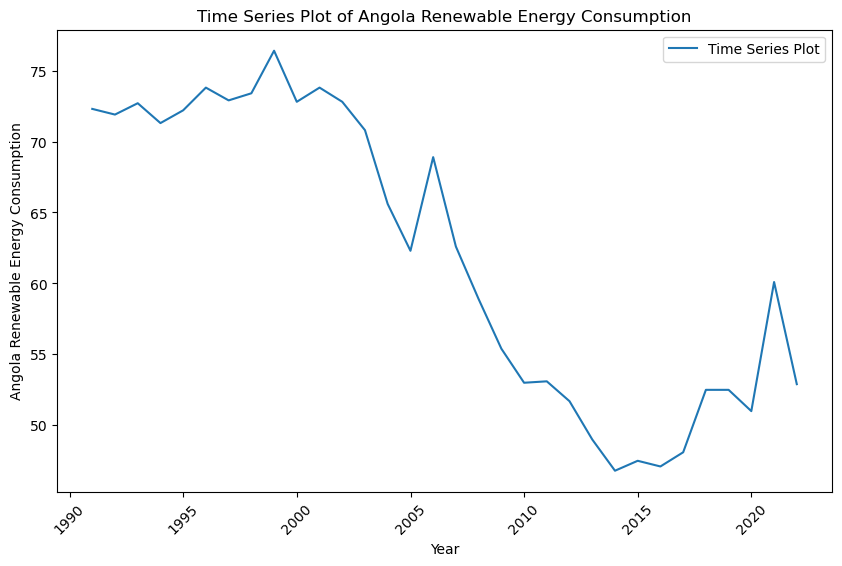

In [392]:
# Load your time series data
data = pd.read_excel(r'ONISMUS DATA.xlsx')
data1 = data ['Angola']
# Descriptive statistics
print(data1.describe())
print(data1.info())

years = pd.date_range(start='1990', end='2022', freq='Y')

# Ensure the index of the DataFrame is set to the correct years
data1.index = years

# Plot the time series with actual years on the x-axis
plt.figure(figsize=(10,6))
plt.plot(data1, label="Time Series Plot")
plt.title("Time Series Plot of Angola Renewable Energy Consumption")
plt.xlabel("Year")
plt.ylabel("Angola Renewable Energy Consumption")
plt.legend()

# Set the x-axis to display the years in a less clustered way, e.g., every 5 years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(5))  # Display ticks every 5 years

plt.xticks(rotation=45)  # Rotate the x-axis labels to make them more readable

plt.show()

In [393]:
127-49

78

# ARIMA Model

### Plot ACF and PACF of the Series

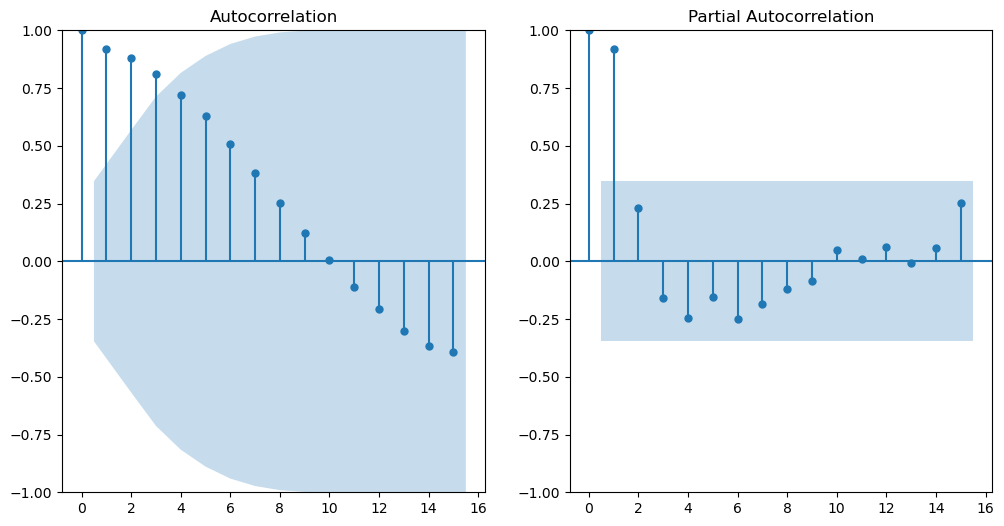

In [394]:
# Plot ACF and PACF
plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(data1, ax=plt.gca(), lags=15)
plt.subplot(122)
plot_pacf(data1, ax=plt.gca(), lags=15)
plt.show()

### Perform ADF Test on Actual Series

In [395]:
adf_result1 = adfuller(data1)
print('ADF Statistic: %f' % adf_result1[0])
print('p-value: %f' % adf_result1[1])

ADF Statistic: -0.947849
p-value: 0.771807


### Differencing the Actual Series 

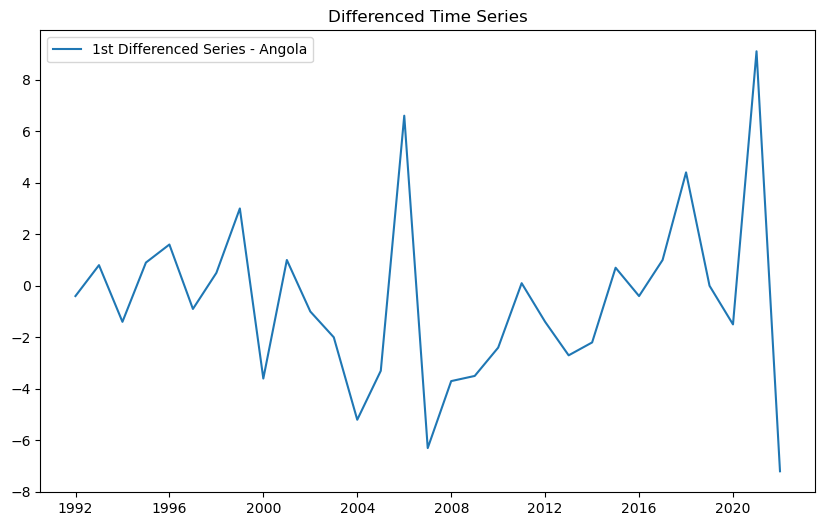

In [396]:
# Difference the series to make it stationary
data1_diff = data1.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(10,6))
plt.plot(data1_diff, label="1st Differenced Series - Angola")
plt.title("Differenced Time Series")
plt.legend()
plt.show()

###  Plot ACF and PACF of the 1st Differenced Series

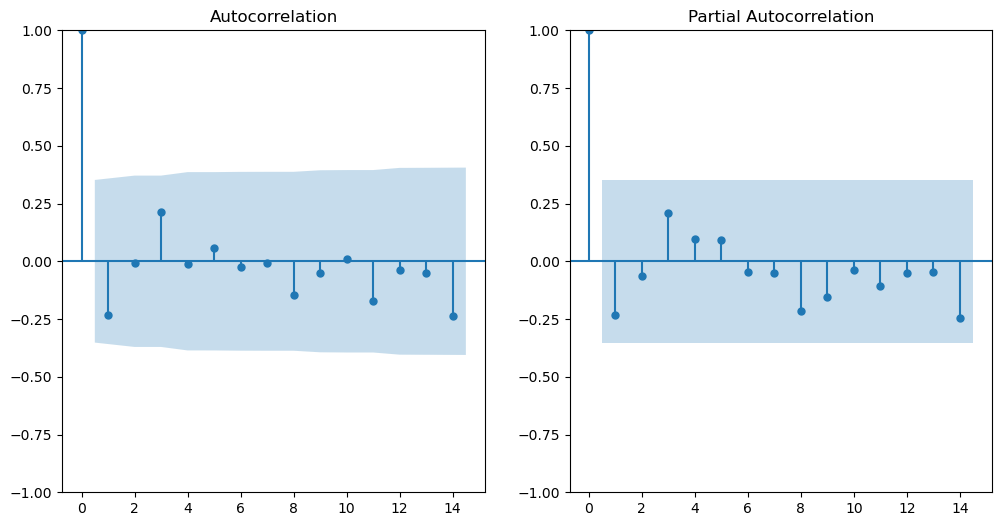

Differenced ADF Statistic: -6.477111
Differenced p-value: 0.000000


In [397]:
# ACF and PACF of differenced series
plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(data1_diff, ax=plt.gca(), lags=14)
plt.subplot(122)
plot_pacf(data1_diff, ax=plt.gca(), lags=14)
plt.show()

# ADF Test on differenced series
adf_diff_result = adfuller(data1_diff)
print('Differenced ADF Statistic: %f' % adf_diff_result[0])
print('Differenced p-value: %f' % adf_diff_result[1])

### Hyperparameter Tuning for ARIMA

In [398]:
import itertools
import warnings
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Suppress warnings
warnings.filterwarnings("ignore")

# Define parameter ranges to test (example ranges)
p = d = q = range(0, 3)  # Try values 0, 1, 2
pdq = list(itertools.product(p, d, q))  # Generate all combinations

# Function to evaluate ARIMA models
def evaluate_arima_models(data1, pdq_combinations):
    best_aic = np.inf
    best_order = None
    best_model = None
    
    for order in pdq_combinations:
        try:
            model = ARIMA(data1, order=order).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = order
                best_model = model
        except:
            continue
    
    return best_order, best_model

In [399]:
## Find the best ARIMA model
best_order, best_arima_model1 = evaluate_arima_models(data1, pdq)

# Print results
print(f"Best ARIMA Order: {best_order}")
print(best_arima_model1.summary())


Best ARIMA Order: (0, 2, 2)
                               SARIMAX Results                                
Dep. Variable:                 Angola   No. Observations:                   32
Model:                 ARIMA(0, 2, 2)   Log Likelihood                 -78.533
Date:                Sat, 13 Dec 2025   AIC                            163.067
Time:                        18:07:56   BIC                            167.270
Sample:                    12-31-1990   HQIC                           164.411
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.3492      0.195     -6.909      0.000      -1.732      -0.966
ma.L2          0.6413      0.211      3.043      0.002       0.228       1.054
sigma2        10.2247   

In [400]:
import itertools
import warnings
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# Expanded but safe parameter grid
p = range(0, 4)
d = range(0, 3)
q = range(0, 4)
pdq = list(itertools.product(p, d, q))

successful_models = []
best_aic = np.inf
best_order = None
best_model = None

print("Fitting models... please wait\n")

for order in pdq:
    try:
        model = ARIMA(data1, order=order).fit(method_kwargs={"warn_convergence": False})

        # Skip exploding or non-invertible models
        if model.aic == np.inf or model.aic > 1e10:
            continue

        successful_models.append((order, model.aic))

        if model.aic < best_aic:
            best_aic = model.aic
            best_order = order
            best_model = model

        print(f"Fitted ARIMA{order}  AIC = {model.aic}")

    except Exception as e:
        # Debug only if needed:
        # print(f"Failed ARIMA{order}: {e}")
        pass

print("\n===============================")
print(" BEST ARIMA MODEL FOUND ")
print("===============================")
print(f"Order: {best_order}")
print(f"AIC:   {best_model.aic}")
print(f"BIC:   {best_model.bic}")
print(f"HQIC:  {best_model.hqic}")
print(f"Sigma: {best_model.scale}")
print(f"No. of significant params: {np.sum(best_model.pvalues < 0.05)}")

Fitting models... please wait

Fitted ARIMA(0, 0, 0)  AIC = 243.62652626063624
Fitted ARIMA(0, 0, 1)  AIC = 213.2216648707597
Fitted ARIMA(0, 0, 2)  AIC = 205.91726740714384
Fitted ARIMA(0, 0, 3)  AIC = 195.89472211387113
Fitted ARIMA(0, 1, 0)  AIC = 165.99325494788445
Fitted ARIMA(0, 1, 1)  AIC = 166.7441112404517
Fitted ARIMA(0, 1, 2)  AIC = 167.53222113011972
Fitted ARIMA(0, 1, 3)  AIC = 167.01489683696252
Fitted ARIMA(0, 2, 0)  AIC = 186.2239963641722
Fitted ARIMA(0, 2, 1)  AIC = 166.09182957550738
Fitted ARIMA(0, 2, 2)  AIC = 163.06669407860932
Fitted ARIMA(0, 2, 3)  AIC = 165.01820810912682
Fitted ARIMA(1, 0, 0)  AIC = 176.51100232897227
Fitted ARIMA(1, 0, 1)  AIC = 177.4670474451393
Fitted ARIMA(1, 0, 2)  AIC = 178.0641451517002
Fitted ARIMA(1, 0, 3)  AIC = 177.52733934015316
Fitted ARIMA(1, 1, 0)  AIC = 166.48745003183137
Fitted ARIMA(1, 1, 1)  AIC = 168.47946332161726
Fitted ARIMA(1, 1, 2)  AIC = 165.7456243515037
Fitted ARIMA(1, 1, 3)  AIC = 166.81462629808283
Fitted ARIMA(1,

### Fit Two More ARIMA Models

In [401]:
# Fit two other ARIMA models with different orders
arima_model_1 = ARIMA(data1, order=(0,1,0)).fit()
arima_model_2 = ARIMA(data1, order=(0,1,1)).fit()
arima_model_3 = ARIMA(data1, order=(0,1,2)).fit()
arima_model_4 = ARIMA(data1, order=(0,2,0)).fit()
arima_model_5 = ARIMA(data1, order=(0,2,1)).fit()
arima_model_6 = ARIMA(data1, order=(1,1,1)).fit()


# Compare AIC, BIC, HQIC, LogLikelihood
print(f"ARIMA (Best) AIC: {best_arima_model1.aic}, BIC: {best_arima_model1.bic}, HQIC: {best_arima_model1.hqic}")
print(f"ARIMA (0,1,0) AIC: {arima_model_1.aic}, BIC: {arima_model_1.bic},  HQIC: {arima_model_1.hqic}")
print(f"ARIMA (0,1,1) AIC: {arima_model_2.aic}, BIC: {arima_model_2.bic},  HQIC: {arima_model_2.hqic}")
print(f"ARIMA (0,1, 2) AIC: {arima_model_3.aic}, BIC: {arima_model_3.bic}, HQIC: {arima_model_3.hqic}")
print(f"ARIMA (0,2,0) AIC: {arima_model_4.aic}, BIC: {arima_model_4.bic},  HQIC: {arima_model_4.hqic}")
print(f"ARIMA (0,2,1) AIC: {arima_model_5.aic}, BIC: {arima_model_5.bic},  HQIC: {arima_model_5.hqic}")

ARIMA (Best) AIC: 163.06669407860932, BIC: 167.27028622359578, HQIC: 164.41145932281856
ARIMA (0,1,0) AIC: 165.99325494788445, BIC: 167.4272421523696,  HQIC: 166.4606990205702
ARIMA (0,1,1) AIC: 166.7441112404517, BIC: 169.612085649422,  HQIC: 167.6789993858232
ARIMA (0,1, 2) AIC: 167.53222113011972, BIC: 171.83418274357516, HQIC: 168.93455334817696
ARIMA (0,2,0) AIC: 186.2239963641722, BIC: 187.62519374583434,  HQIC: 186.67225144557528
ARIMA (0,2,1) AIC: 166.09182957550738, BIC: 168.8942243388317,  HQIC: 166.98833973831356


In [402]:
print(best_arima_model1.summary())

print(arima_model_2.summary())

print(arima_model_6.summary())

                               SARIMAX Results                                
Dep. Variable:                 Angola   No. Observations:                   32
Model:                 ARIMA(0, 2, 2)   Log Likelihood                 -78.533
Date:                Sat, 13 Dec 2025   AIC                            163.067
Time:                        18:08:14   BIC                            167.270
Sample:                    12-31-1990   HQIC                           164.411
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.3492      0.195     -6.909      0.000      -1.732      -0.966
ma.L2          0.6413      0.211      3.043      0.002       0.228       1.054
sigma2        10.2247      2.798      3.654      0.0

### Predict Using the Best ARIMA Model

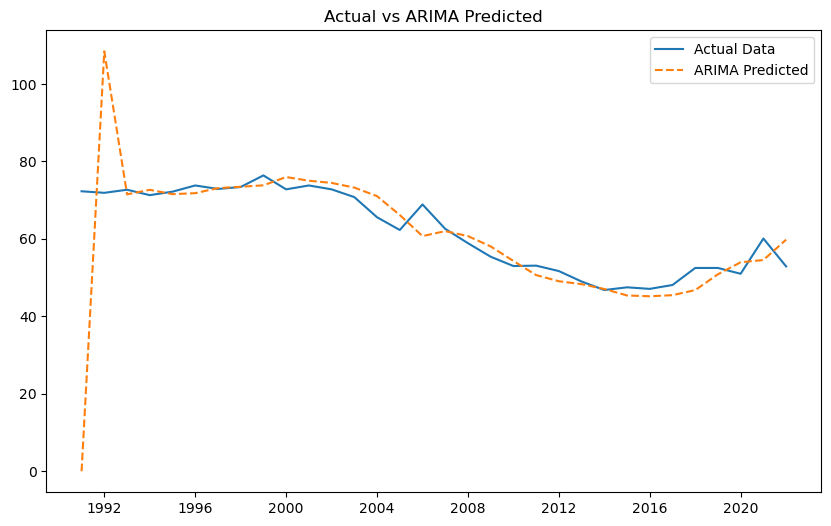

ARIMA Model - R-squared: -1.0526652883097554, MSE: 214.7749996400841, MAPE: 0.08714719560432252, AIC: 163.06669407860932, BIC: 167.27028622359578


In [403]:
# Predictions using best ARIMA model
pred_arima1 = best_arima_model1.predict(start=0, end=len(data1)-1)

# Plot Actual vs Predicted
plt.figure(figsize=(10,6))
plt.plot(data1, label='Actual Data')
plt.plot(data1.index, pred_arima1, label='ARIMA Predicted', linestyle='--')
plt.title('Actual vs ARIMA Predicted')
plt.legend()
plt.show()


# Compute performance metrics for ARIMA model
mse_arima1 = mean_squared_error(data1, pred_arima1)
r2_arima1 = r2_score(data1, pred_arima1)
mape_arima1 = mean_absolute_percentage_error(data1, pred_arima1)
aic_arima1 = best_arima_model1.aic
bic_arima1 = best_arima_model1.bic

print(f"ARIMA Model - R-squared: {r2_arima1}, MSE: {mse_arima1}, MAPE: {mape_arima1}, AIC: {aic_arima1}, BIC: {bic_arima1}")


In [404]:
future_forecast1 = best_arima_model1.forecast(steps=5) 
future_forecast1

2022-12-31    58.579944
2023-12-31    59.830299
2024-12-31    61.080654
2025-12-31    62.331009
2026-12-31    63.581364
Freq: YE-DEC, Name: predicted_mean, dtype: float64

## Fit the Grey-box Model

### Greybox modeling of time series data typically involves combining a classical time series model (like ARIMA, which forms the Whitebox component) with a data-driven model (such as a machine learning model like a neural network or random forest, which forms the Blackbox component) to enhance the predictive accuracy.

In [405]:
# Step 1: Fit the ARIMA model
arima_model_1 = ARIMA(data1, order=(0,2,2)).fit()

# Step 2: Get the ARIMA predictions and residuals
arima_pred1 = arima_model_1.fittedvalues
residuals1 = data1 - arima_pred1  # Residuals from ARIMA model

# Step 3: Fit a RandomForest model (Blackbox model) on the residuals
# Use lag features of the residuals as inputs
lags1 = 3  # Number of lagged features
X = pd.DataFrame({f'lag_{i}': residuals1.shift(i) for i in range(1, lags1 + 1)})

# Replace missing values (from lagging) using column mean
X.fillna(X.mean(), inplace=True)

# Define target variable y after aligning with X (dropping the first `lags` rows)
y = residuals1[lags1:]  # Align y to match the length of X
X = X[lags1:]  # Align X by removing the first `lags` rows

# Fit the RandomForest model
rf_model1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model1.fit(X, y)

# Step 4: Make predictions using the Random Forest model
rf_pred1 = rf_model1.predict(X)

# Combine ARIMA and RandomForest predictions: Final prediction = ARIMA prediction + RF residual prediction
rf_forecast_residuals1 = rf_pred1  # Residuals predicted by Random Forest
final_forecast1 = arima_pred1[lags1:] + rf_forecast_residuals1  # Combine ARIMA and RF predictions


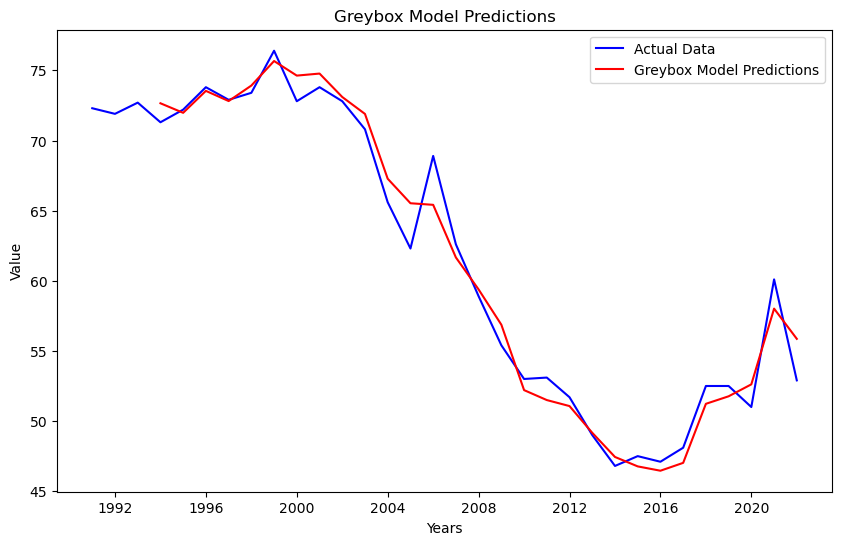

In [406]:
# Step 5: Plot the final combined predictions (Greybox model)
plt.figure(figsize=(10, 6))
plt.plot(years, data1, label="Actual Data", color='blue')
plt.plot(years[lags1:], final_forecast1, label="Greybox Model Predictions", color='red')
plt.title("Greybox Model Predictions")
plt.xlabel("Years")
plt.ylabel("Value")
plt.legend()
plt.show()



In [407]:
# Step 6: Compute evaluation metrics for the Greybox model predictions
mse1 = mean_squared_error(data1[lags1:], final_forecast1)
mape1 = mean_absolute_percentage_error(data1[lags1:], final_forecast1)
r2 = r2_score(data1[lags1:], final_forecast1)

print(f'Greybox Model Evaluation:')
print(f'R-Squared: {r2:.4f}')
print(f'MSE: {mse1:.4f}')
print(f'MAPE: {mape1:.4f}')

Greybox Model Evaluation:
R-Squared: 0.9797
MSE: 2.1032
MAPE: 0.0195


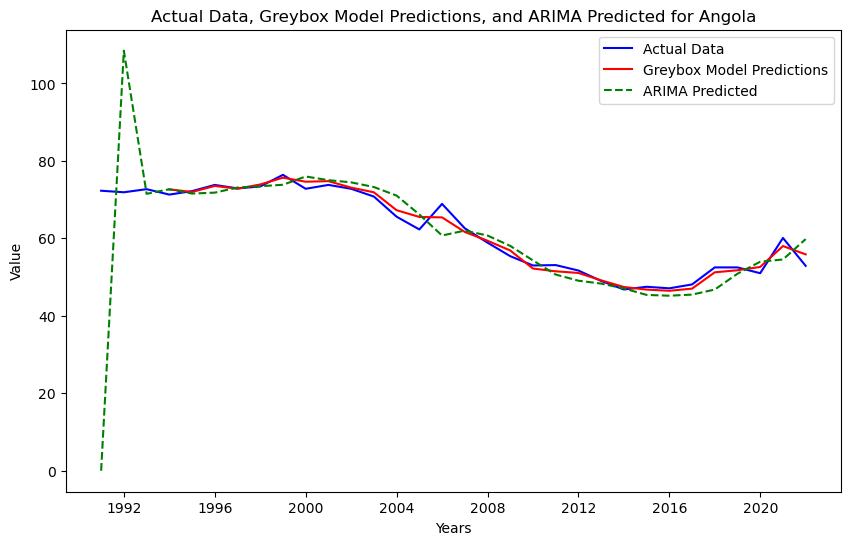

In [408]:
plt.figure(figsize=(10, 6))

# Plot Actual Data
plt.plot(years, data1, label="Actual Data", color='blue')

# Plot Greybox Model Predictions
plt.plot(years[lags1:], final_forecast1, label="Greybox Model Predictions", color='red')

# Plot ARIMA Predicted Data
plt.plot(years, pred_arima1, label='ARIMA Predicted', linestyle='--', color='green')

# Add titles, labels, and legend
plt.title("Actual Data, Greybox Model Predictions, and ARIMA Predicted for Angola")
plt.xlabel("Years")
plt.ylabel("Value")
plt.legend()

# Show the combined plot
plt.show()


# ANALYSING CANADA DATASET

## DESCRIPTIVE ANALYSIS OF THE TIME SERIES

count    32.00000
mean     21.88125
std       0.97499
min      19.70000
25%      21.57500
50%      22.15000
75%      22.32500
max      23.90000
Name: Canada, dtype: float64
<class 'pandas.core.series.Series'>
RangeIndex: 32 entries, 0 to 31
Series name: Canada
Non-Null Count  Dtype  
--------------  -----  
32 non-null     float64
dtypes: float64(1)
memory usage: 388.0 bytes
None


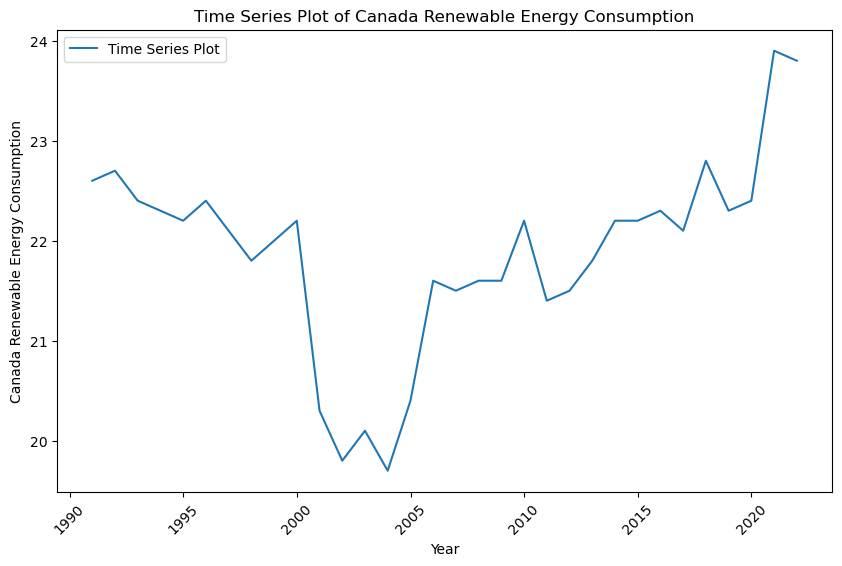

In [409]:
data2 = data['Canada']
# Descriptive statistics
print(data2.describe())
print(data2.info())

years = pd.date_range(start='1990', end='2022', freq='Y')

# Ensure the index of the DataFrame is set to the correct years
data2.index = years

# Plot the time series with actual years on the x-axis
plt.figure(figsize=(10,6))
plt.plot(data2, label="Time Series Plot")
plt.title("Time Series Plot of Canada Renewable Energy Consumption")
plt.xlabel("Year")
plt.ylabel("Canada Renewable Energy Consumption")
plt.legend()

# Set the x-axis to display the years in a less clustered way, e.g., every 5 years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(5))  # Display ticks every 5 years

plt.xticks(rotation=45)  # Rotate the x-axis labels to make them more readable

plt.show()

## ARIMA Model

# Plot ACF and PACF of the Series

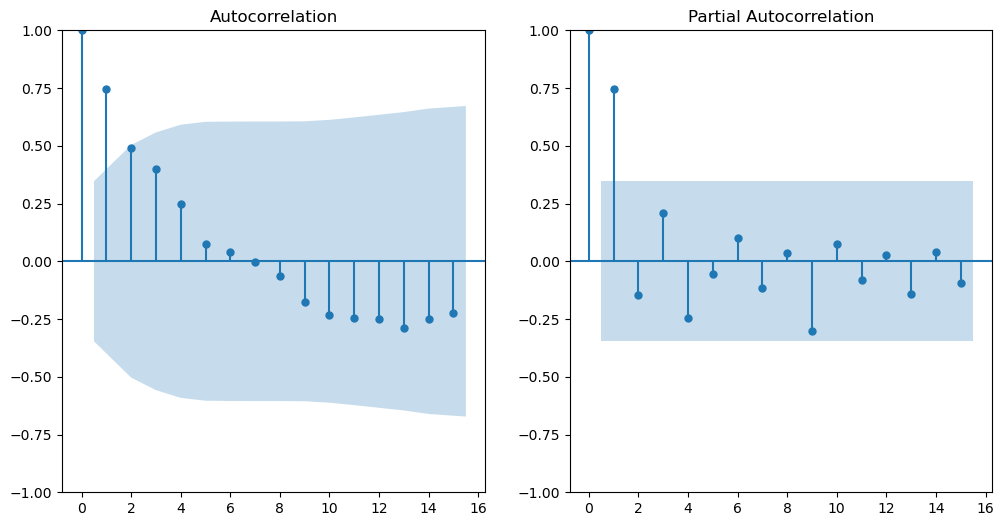

In [410]:
# Plot ACF and PACF
plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(data2, ax=plt.gca(), lags=15)
plt.subplot(122)
plot_pacf(data2, ax=plt.gca(), lags=15)
plt.show()

## Perform ADF Test on Actual Series

In [411]:
adf_result = adfuller(data2)
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

ADF Statistic: -1.245324
p-value: 0.653801


## Differencing the Actual Series

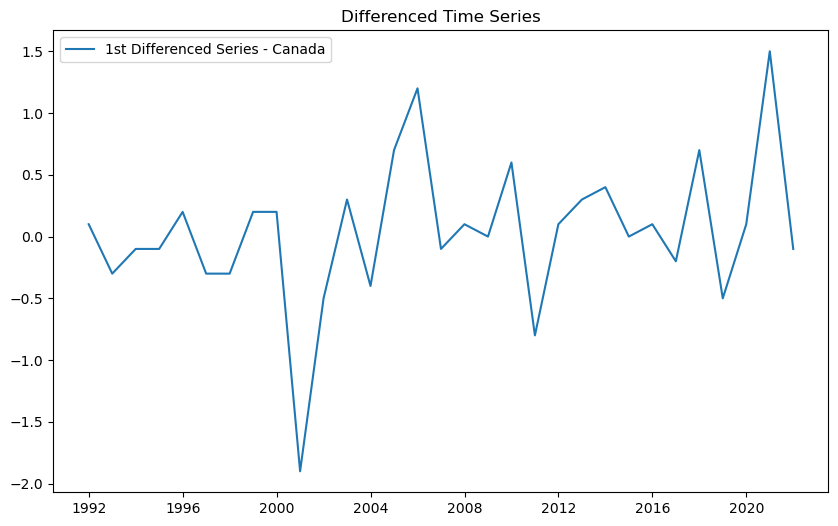

In [412]:
# Difference the series to make it stationary
data2_diff = data2.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(10,6))
plt.plot(data2_diff, label="1st Differenced Series - Canada")
plt.title("Differenced Time Series")
plt.legend()
plt.show()

## Plot ACF and PACF of the 1st Differenced Series¶

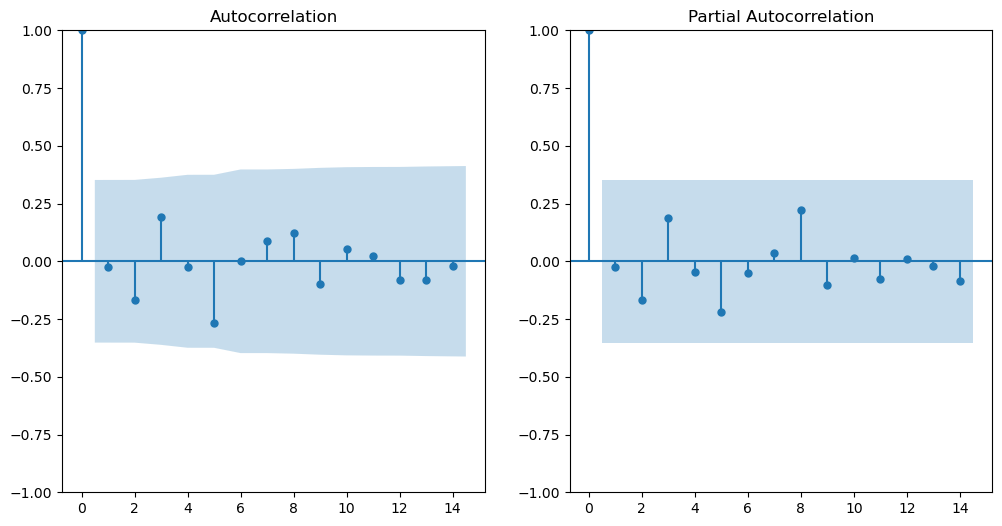

Differenced ADF Statistic: -5.431220
Differenced p-value: 0.000003


In [413]:
# ACF and PACF of differenced series
plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(data2_diff, ax=plt.gca(), lags=14)
plt.subplot(122)
plot_pacf(data2_diff, ax=plt.gca(), lags=14)
plt.show()

# ADF Test on differenced series
adf_diff_result2 = adfuller(data2_diff)
print('Differenced ADF Statistic: %f' % adf_diff_result2[0])
print('Differenced p-value: %f' % adf_diff_result2[1])

## Hyperparameter Tuning for ARIMA

In [414]:
# Define parameter ranges to test (example ranges)
p = d = q = range(0, 3)  # Try values 0, 1, 2
pdq = list(itertools.product(p, d, q))  # Generate all combinations

# Function to evaluate ARIMA models
def evaluate_arima_models(data2, pdq_combinations):
    best_aic = np.inf
    best_order = None
    best_model = None
    
    for order in pdq_combinations:
        try:
            model = ARIMA(data2, order=order).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = order
                best_model = model
        except:
            continue
    
    return best_order, best_model
# Find the best ARIMA model
best_order, best_arima_model2 = evaluate_arima_models(data2, pdq)

# Print results
print(f"Best ARIMA Order: {best_order}")
print(best_arima_model2.summary())


Best ARIMA Order: (0, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                 Canada   No. Observations:                   32
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -27.643
Date:                Sat, 13 Dec 2025   AIC                             57.287
Time:                        18:08:26   BIC                             58.721
Sample:                    12-31-1990   HQIC                            57.754
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3484      0.058      6.029      0.000       0.235       0.462
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                11.44
Prob(Q):           

## Fit Two More ARIMA Models

In [415]:
# Fit two other ARIMA models with different orders
arima_model_1 = ARIMA(data2, order=(0,1,1)).fit()
arima_model_2 = ARIMA(data2, order=(1,1,1)).fit()
arima_model_3 = ARIMA(data2, order=(1,1,0)).fit()
arima_model_4 = ARIMA(data2, order=(0,1,2)).fit()
arima_model_5 = ARIMA(data2, order=(1,1,2)).fit()
arima_model_6 = ARIMA(data2, order=(0,2,1)).fit()
arima_model_7 = ARIMA(data2, order=(2,1,1)).fit()

# Compare AIC, BIC, HQIC, LogLikelihood
print(f"ARIMA (Best) AIC: {best_arima_model2.aic}, BIC: {best_arima_model2.bic}, HQIC: {best_arima_model2.hqic}")
print(f"ARIMA (0,1,1) AIC: {arima_model_1.aic}, BIC: {arima_model_1.bic},  HQIC: {arima_model_1.hqic}")
print(f"ARIMA (1,1,1) AIC: {arima_model_2.aic}, BIC: {arima_model_2.bic}, HQIC: {arima_model_2.hqic}")
print(f"ARIMA (1,1,0) AIC: {arima_model_3.aic}, BIC: {arima_model_3.bic},  HQIC: {arima_model_3.hqic}")
print(f"ARIMA (0,1,2) AIC: {arima_model_4.aic}, BIC: {arima_model_4.bic},  HQIC: {arima_model_4.hqic}")
print(f"ARIMA (1,1,2) AIC: {arima_model_5.aic}, BIC: {arima_model_5.bic},  HQIC: {arima_model_5.hqic}")
print(f"ARIMA (0,2,1) AIC: {arima_model_6.aic}, BIC: {arima_model_6.bic},  HQIC: {arima_model_6.hqic}")

ARIMA (Best) AIC: 57.286515881416285, BIC: 58.720503085901434, HQIC: 57.75395995410204
ARIMA (0,1,1) AIC: 59.26503106608009, BIC: 62.13300547505038,  HQIC: 60.199919211451586
ARIMA (1,1,1) AIC: 60.718123679114534, BIC: 65.02008529256997, HQIC: 62.12045589717178
ARIMA (1,1,0) AIC: 59.27165540028382, BIC: 62.13962980925411,  HQIC: 60.20654354565532
ARIMA (0,1,2) AIC: 60.201405917922166, BIC: 64.5033675313776,  HQIC: 61.60373813597941
ARIMA (1,1,2) AIC: 62.06835924422117, BIC: 67.80430806216175,  HQIC: 63.93813553496417
ARIMA (0,2,1) AIC: 61.646831738680156, BIC: 64.44922650200446,  HQIC: 62.54334190148632


In [416]:
print(arima_model_5.summary())

print(arima_model_6.summary())

print(arima_model_7.summary())

                               SARIMAX Results                                
Dep. Variable:                 Canada   No. Observations:                   32
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 -27.034
Date:                Sat, 13 Dec 2025   AIC                             62.068
Time:                        18:08:27   BIC                             67.804
Sample:                    12-31-1990   HQIC                            63.938
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2226      1.418     -0.157      0.875      -3.001       2.556
ma.L1          0.2348      1.484      0.158      0.874      -2.674       3.143
ma.L2         -0.1763      0.489     -0.360      0.7

## Predict Using the Best ARIMA Model

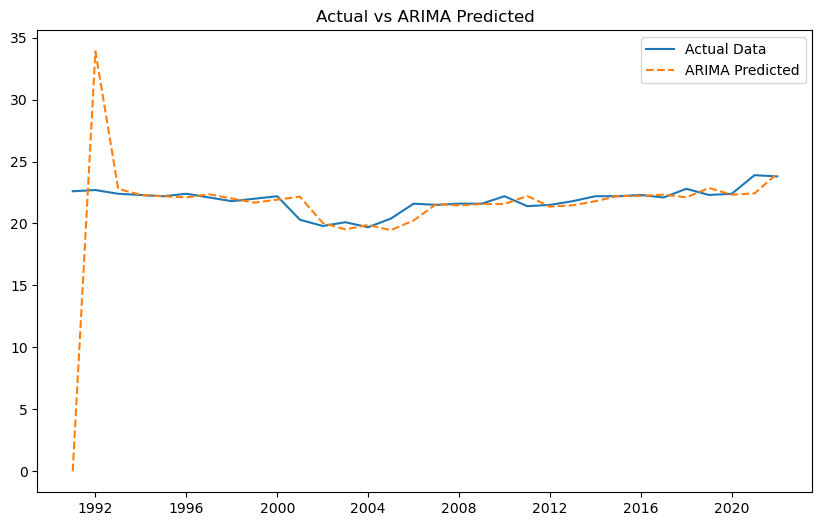

ARIMA Model - R-squared: -20.982474966033102, MSE: 20.24362684860274, MAPE: 0.06519305458026375, AIC: 61.646831738680156, BIC: 64.44922650200446


In [417]:
# Predictions using best ARIMA model
pred_arima2 = arima_model_6.predict(start=0, end=len(data2)-1)

# Plot Actual vs Predicted
plt.figure(figsize=(10,6))
plt.plot(data2, label='Actual Data')
plt.plot(data2.index, pred_arima2, label='ARIMA Predicted', linestyle='--')
plt.title('Actual vs ARIMA Predicted')
plt.legend()
plt.show()


# Compute performance metrics for ARIMA model
mse_arima2 = mean_squared_error(data2, pred_arima2)
r2_arima2 = r2_score(data2, pred_arima2)
mape_arima2 = mean_absolute_percentage_error(data2, pred_arima2)
aic_arima2 = arima_model_6.aic
bic_arima2 = arima_model_6.bic

print(f"ARIMA Model - R-squared: {r2_arima2}, MSE: {mse_arima2}, MAPE: {mape_arima2}, AIC: {aic_arima2}, BIC: {bic_arima2}")


In [418]:
future_forecast2 = arima_model_6.forecast(steps=5) 
future_forecast2

2022-12-31    23.915515
2023-12-31    24.031029
2024-12-31    24.146544
2025-12-31    24.262059
2026-12-31    24.377573
Freq: YE-DEC, Name: predicted_mean, dtype: float64

## Fit the Grey-box Model

### Greybox modeling of time series data typically involves combining a classical time series model (like ARIMA, which forms the Whitebox component) with a data-driven model (such as a machine learning model like a neural network or random forest, which forms the Blackbox component) to enhance the predictive accuracy.

In [419]:
# Step 1: Fit the ARIMA model
arima_model_1 = ARIMA(data2, order=(0,2,1)).fit()

# Step 2: Get the ARIMA predictions and residuals
arima_pred2 = arima_model_1.fittedvalues
residuals2 = data2 - arima_pred2  # Residuals from ARIMA model

# Step 3: Fit a RandomForest model (Blackbox model) on the residuals
# Use lag features of the residuals as inputs
lags2 = 3  # Number of lagged features
X = pd.DataFrame({f'lag_{i}': residuals2.shift(i) for i in range(1, lags2 + 1)})

# Replace missing values (from lagging) using column mean
X.fillna(X.mean(), inplace=True)

# Define target variable y after aligning with X (dropping the first `lags` rows)
y = residuals2[lags2:]  # Align y to match the length of X
X = X[lags2:]  # Align X by removing the first `lags` rows

# Fit the RandomForest model
rf_model2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model2.fit(X, y)

# Step 4: Make predictions using the Random Forest model
rf_pred2 = rf_model2.predict(X)

# Combine ARIMA and RandomForest predictions: Final prediction = ARIMA prediction + RF residual prediction
rf_forecast_residuals2 = rf_pred2  # Residuals predicted by Random Forest
final_forecast2 = arima_pred2[lags2:] + rf_forecast_residuals2  # Combine ARIMA and RF predictions


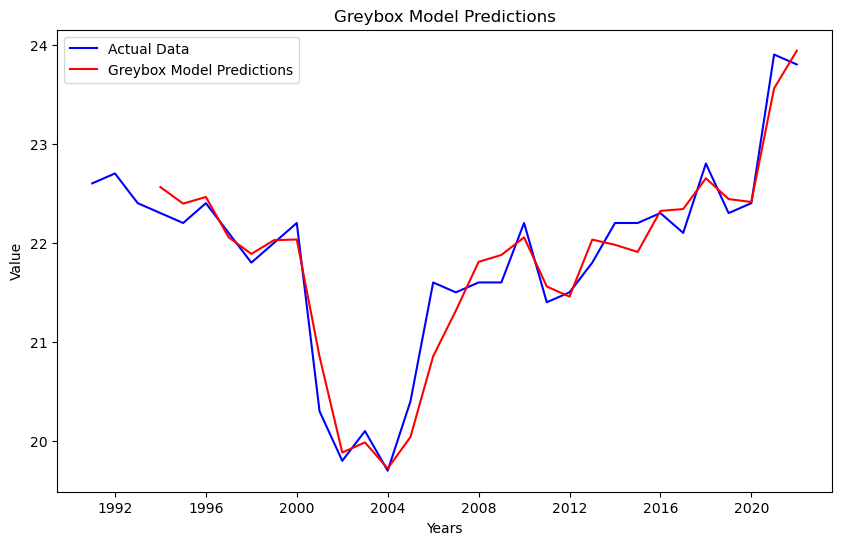

In [420]:
# Step 5: Plot the final combined predictions (Greybox model)
plt.figure(figsize=(10, 6))
plt.plot(years, data2, label="Actual Data", color='blue')
plt.plot(years[lags2:], final_forecast2, label="Greybox Model Predictions", color='red')
plt.title("Greybox Model Predictions")
plt.xlabel("Years")
plt.ylabel("Value")
plt.legend()
plt.show()



In [421]:
# Step 6: Compute evaluation metrics for the Greybox model predictions
mse2 = mean_squared_error(data2[lags2:], final_forecast2)
mape2 = mean_absolute_percentage_error(data2[lags2:], final_forecast2)
r2 = r2_score(data2[lags2:], final_forecast2)

print(f'Greybox Model Evaluation:')
print(f'R-Squared: {r2:.4f}')
print(f'MSE: {mse2:.4f}')
print(f'MAPE: {mape2:.4f}')

Greybox Model Evaluation:
R-Squared: 0.9360
MSE: 0.0615
MAPE: 0.0088


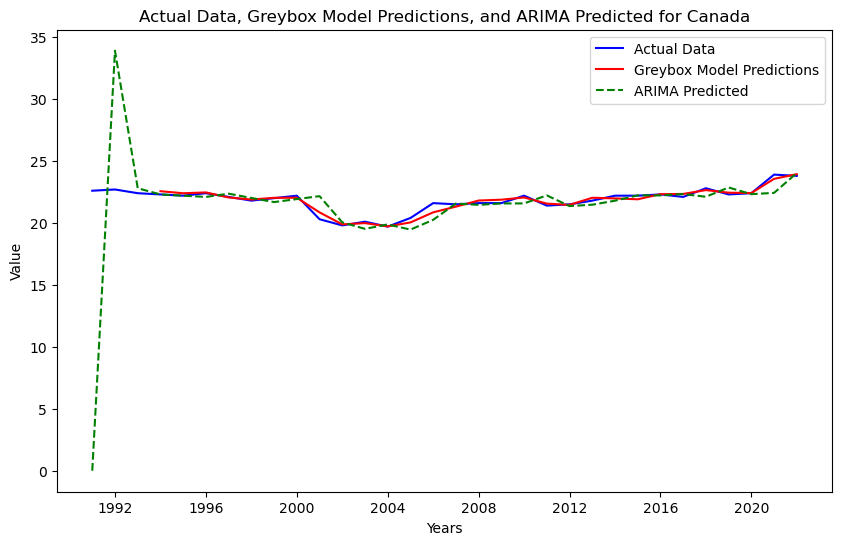

In [422]:
plt.figure(figsize=(10, 6))

# Plot Actual Data
plt.plot(years, data2, label="Actual Data", color='blue')

# Plot Greybox Model Predictions
plt.plot(years[lags2:], final_forecast2, label="Greybox Model Predictions", color='red')

# Plot ARIMA Predicted Data
plt.plot(years, pred_arima2, label='ARIMA Predicted', linestyle='--', color='green')

# Add titles, labels, and legend
plt.title("Actual Data, Greybox Model Predictions, and ARIMA Predicted for Canada")
plt.xlabel("Years")
plt.ylabel("Value")
plt.legend()

# Show the combined plot
plt.show()


# ANALYSING FRANCE DATASET

# DESCRIPTIVE ANALYSIS OF THE TIME SERIES

count    32.000000
mean     11.421875
std       2.348333
min       8.500000
25%       9.625000
50%      10.800000
75%      13.225000
max      16.800000
Name: France, dtype: float64
<class 'pandas.core.series.Series'>
RangeIndex: 32 entries, 0 to 31
Series name: France
Non-Null Count  Dtype  
--------------  -----  
32 non-null     float64
dtypes: float64(1)
memory usage: 388.0 bytes
None


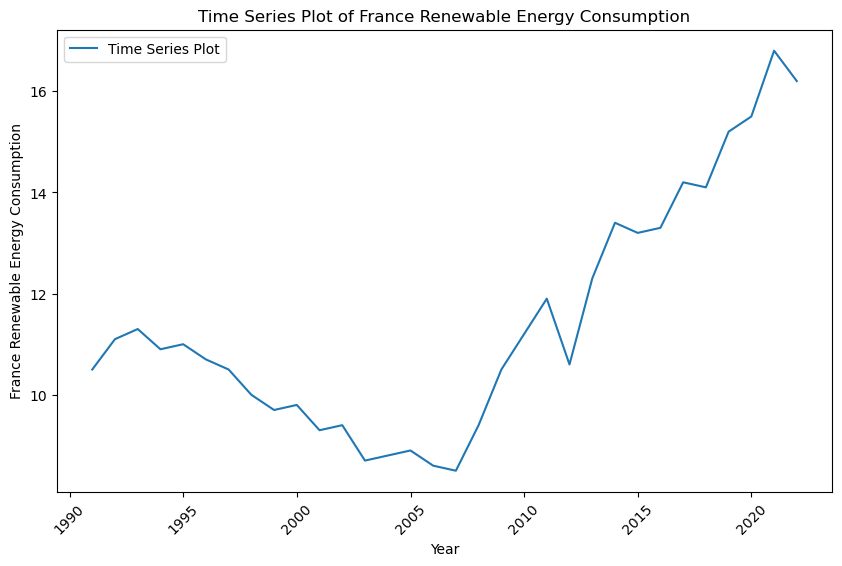

In [423]:
data3 = data ['France']
# Descriptive statistics
print(data3.describe())
print(data3.info())

years = pd.date_range(start='1990', end='2022', freq='Y')

# Ensure the index of the DataFrame is set to the correct years
data3.index = years

# Plot the time series with actual years on the x-axis
plt.figure(figsize=(10,6))
plt.plot(data3, label="Time Series Plot")
plt.title("Time Series Plot of France Renewable Energy Consumption")
plt.xlabel("Year")
plt.ylabel("France Renewable Energy Consumption")
plt.legend()

# Set the x-axis to display the years in a less clustered way, e.g., every 5 years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(5))  # Display ticks every 5 years

plt.xticks(rotation=45)  # Rotate the x-axis labels to make them more readable

plt.show()

### ARIMA Model

## Plot ACF and PACF of the Series

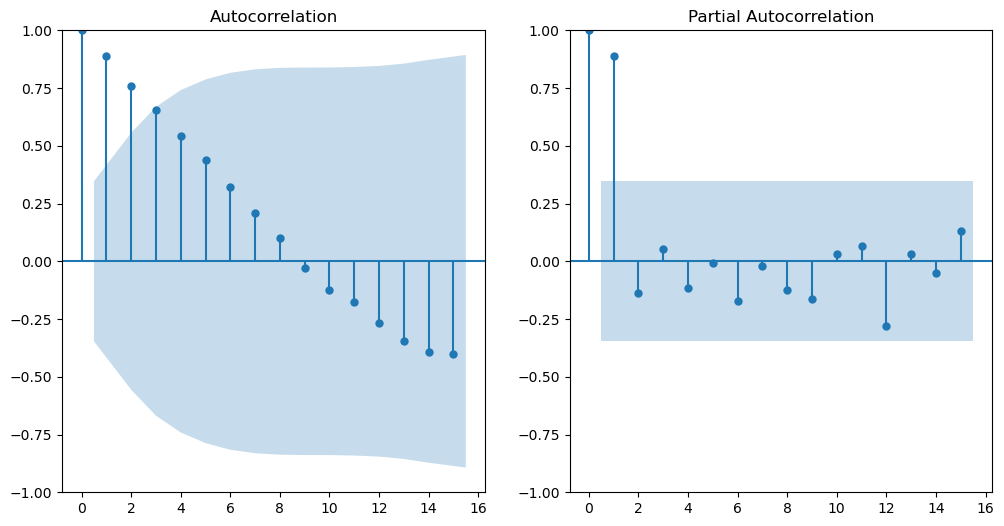

In [424]:
# Plot ACF and PACF
plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(data3, ax=plt.gca(), lags=15)
plt.subplot(122)
plot_pacf(data3, ax=plt.gca(), lags=15)
plt.show()

## Perform ADF Test on Actual Series

In [425]:
adf_result3 = adfuller(data3)
print('ADF Statistic: %f' % adf_result3[0])
print('p-value: %f' % adf_result3[1])

ADF Statistic: 0.526800
p-value: 0.985665


## Differencing the Actual Series

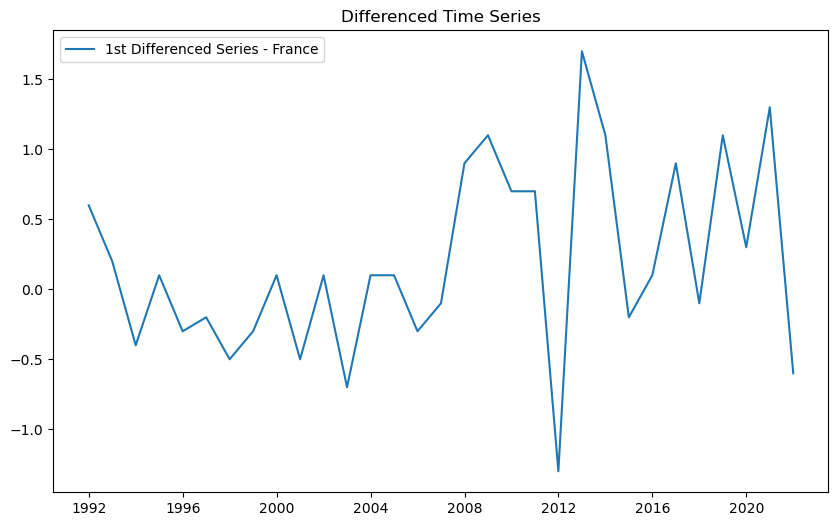

In [426]:
# Difference the series to make it stationary
data3_diff = data3.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(10,6))
plt.plot(data3_diff, label="1st Differenced Series - France")
plt.title("Differenced Time Series")
plt.legend()
plt.show()

## Plot ACF and PACF of the 1st Differenced Series¶

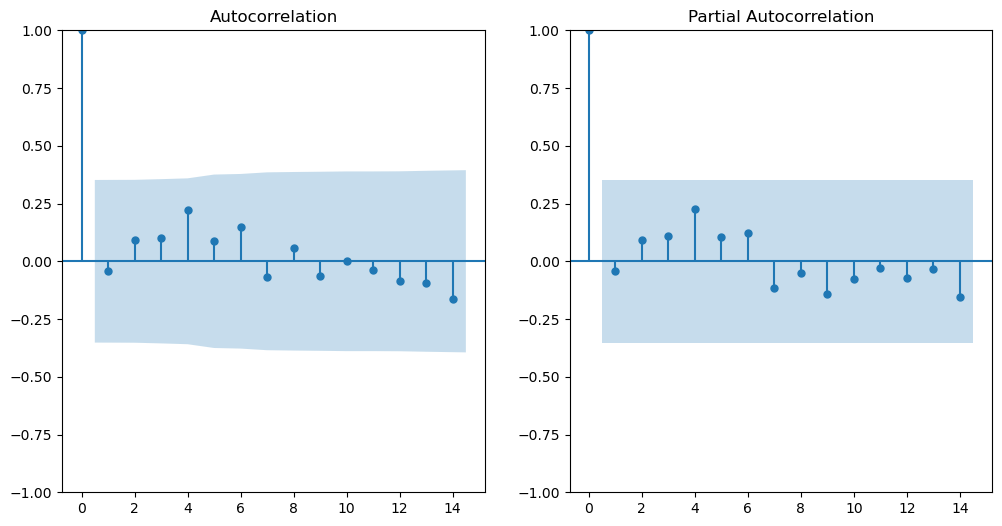

Differenced ADF Statistic: -5.423655
Differenced p-value: 0.000003


In [427]:
# ACF and PACF of differenced series
plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(data3_diff, ax=plt.gca(), lags=14)
plt.subplot(122)
plot_pacf(data3_diff, ax=plt.gca(), lags=14)
plt.show()

# ADF Test on differenced series
adf_diff_result3 = adfuller(data3_diff)
print('Differenced ADF Statistic: %f' % adf_diff_result3[0])
print('Differenced p-value: %f' % adf_diff_result3[1])

## Hyperparameter Tuning for ARIMA

In [428]:
# Define parameter ranges to test (example ranges)
p = d = q = range(0, 3)  # Try values 0, 1, 2
pdq = list(itertools.product(p, d, q))  # Generate all combinations

# Function to evaluate ARIMA models
def evaluate_arima_models(data3, pdq_combinations):
    best_aic = np.inf
    best_order = None
    best_model = None
    
    for order in pdq_combinations:
        try:
            model = ARIMA(data3, order=order).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = order
                best_model = model
        except:
            continue
    
    return best_order, best_model
# Find the best ARIMA model
best_order, best_arima_model3 = evaluate_arima_models(data3, pdq)

# Print results
print(f"Best ARIMA Order: {best_order}")
print(best_arima_model3.summary())


Best ARIMA Order: (0, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                 France   No. Observations:                   32
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -32.663
Date:                Sat, 13 Dec 2025   AIC                             67.325
Time:                        18:08:38   BIC                             68.759
Sample:                    12-31-1990   HQIC                            67.793
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.4816      0.125      3.849      0.000       0.236       0.727
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.56
Prob(Q):           

## Fit Two More ARIMA Models

In [429]:
# Fit two other ARIMA models with different orders
arima_model_1 = ARIMA(data3, order=(0,1,1)).fit()
arima_model_2 = ARIMA(data3, order=(1,1,1)).fit()
arima_model_3 = ARIMA(data3, order=(1,1,0)).fit()
arima_model_4 = ARIMA(data3, order=(0,1,2)).fit()
arima_model_5 = ARIMA(data3, order=(1,1,2)).fit()
arima_model_6 = ARIMA(data3, order=(0,2,1)).fit()
arima_model_7 = ARIMA(data3, order=(2,1,1)).fit()

# Compare AIC, BIC, HQIC, LogLikelihood
print(f"ARIMA (Best) AIC: {best_arima_model2.aic}, BIC: {best_arima_model2.bic}, HQIC: {best_arima_model2.hqic}")
print(f"ARIMA (0,1,1) AIC: {arima_model_1.aic}, BIC: {arima_model_1.bic},  HQIC: {arima_model_1.hqic}")
print(f"ARIMA (1,1,1) AIC: {arima_model_2.aic}, BIC: {arima_model_2.bic}, HQIC: {arima_model_2.hqic}")
print(f"ARIMA (1,1,0) AIC: {arima_model_3.aic}, BIC: {arima_model_3.bic},  HQIC: {arima_model_3.hqic}")
print(f"ARIMA (0,1,2) AIC: {arima_model_4.aic}, BIC: {arima_model_4.bic},  HQIC: {arima_model_4.hqic}")
print(f"ARIMA (1,1,2) AIC: {arima_model_5.aic}, BIC: {arima_model_5.bic},  HQIC: {arima_model_5.hqic}")
print(f"ARIMA (0,2,1) AIC: {arima_model_6.aic}, BIC: {arima_model_6.bic},  HQIC: {arima_model_6.hqic}")
print(f"ARIMA (2,1,1) AIC: {arima_model_7.aic}, BIC: {arima_model_7.bic},  HQIC: {arima_model_7.hqic}")

ARIMA (Best) AIC: 57.286515881416285, BIC: 58.720503085901434, HQIC: 57.75395995410204
ARIMA (0,1,1) AIC: 69.29515800210937, BIC: 72.16313241107967,  HQIC: 70.23004614748088
ARIMA (1,1,1) AIC: 69.64753581612223, BIC: 73.94949742957768, HQIC: 71.04986803417948
ARIMA (1,1,0) AIC: 69.28689641320788, BIC: 72.15487082217818,  HQIC: 70.22178455857939
ARIMA (0,1,2) AIC: 70.86775954586776, BIC: 75.16972115932319,  HQIC: 72.27009176392501
ARIMA (1,1,2) AIC: 69.60217878462035, BIC: 75.33812760256093,  HQIC: 71.47195507536334
ARIMA (0,2,1) AIC: 68.04277309705907, BIC: 70.84516786038338,  HQIC: 68.93928325986523
ARIMA (2,1,1) AIC: 70.4651331985455, BIC: 76.20108201648608,  HQIC: 72.33490948928849


In [430]:
print(arima_model_1.summary())

print(arima_model_2.summary())

print(arima_model_6.summary())

                               SARIMAX Results                                
Dep. Variable:                 France   No. Observations:                   32
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -32.648
Date:                Sat, 13 Dec 2025   AIC                             69.295
Time:                        18:08:39   BIC                             72.163
Sample:                    12-31-1990   HQIC                            70.230
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0279      0.147      0.189      0.850      -0.261       0.317
sigma2         0.4811      0.132      3.647      0.000       0.223       0.740
Ljung-Box (L1) (Q):                   0.16   Jarque-

## Predict Using the Best ARIMA Model

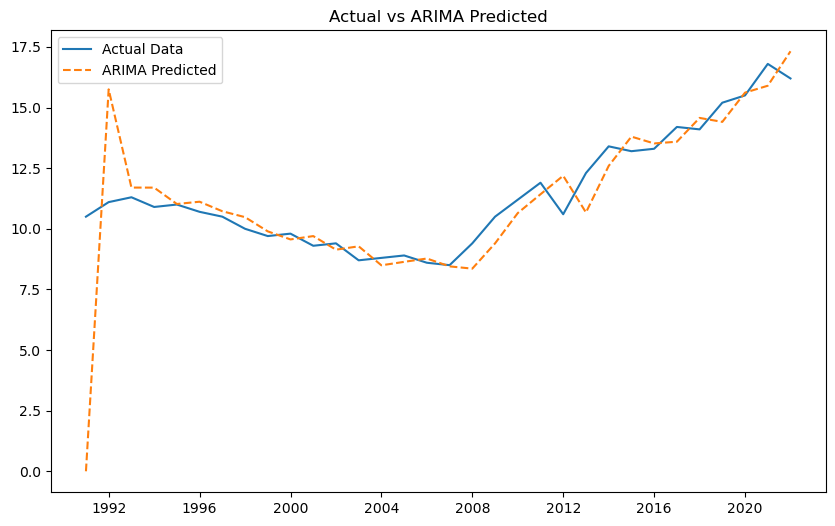

ARIMA Model - R-squared: 0.14402757594294724, MSE: 4.572890570727841, MAPE: 0.08992713941839783, AIC: 68.04277309705907, BIC: 70.84516786038338


In [431]:
# Predictions using best ARIMA model
pred_arima3 = arima_model_6.predict(start=0, end=len(data3)-1)

# Plot Actual vs Predicted
plt.figure(figsize=(10,6))
plt.plot(data3, label='Actual Data')
plt.plot(data3.index, pred_arima3, label='ARIMA Predicted', linestyle='--')
plt.title('Actual vs ARIMA Predicted')
plt.legend()
plt.show()


# Compute performance metrics for ARIMA model
mse_arima3 = mean_squared_error(data3, pred_arima3)
r2_arima3 = r2_score(data3, pred_arima3)
mape_arima3 = mean_absolute_percentage_error(data3, pred_arima3)
aic_arima3 = arima_model_6.aic
bic_arima3 = arima_model_6.bic

print(f"ARIMA Model - R-squared: {r2_arima3}, MSE: {mse_arima3}, MAPE: {mape_arima3}, AIC: {aic_arima3}, BIC: {bic_arima3}")


In [432]:
future_forecast3 = arima_model_6.forecast(steps=5) 
future_forecast3

2022-12-31    16.570273
2023-12-31    16.940546
2024-12-31    17.310818
2025-12-31    17.681091
2026-12-31    18.051364
Freq: YE-DEC, Name: predicted_mean, dtype: float64

### Fit the Grey-box Model

### Greybox modeling of time series data typically involves combining a classical time series model (like ARIMA, which forms the Whitebox component) with a data-driven model (such as a machine learning model like a neural network or random forest, which forms the Blackbox component) to enhance the predictive accuracy.

In [433]:
# Step 1: Fit the ARIMA model
best_arima_model3 = ARIMA(data3, order=(0,2,1)).fit()

# Step 2: Get the ARIMA predictions and residuals
arima_pred3 = best_arima_model3.fittedvalues
residuals3 = data3 - arima_pred3  # Residuals from ARIMA model

# Step 3: Fit a RandomForest model (Blackbox model) on the residuals
# Use lag features of the residuals as inputs
lags3 = 3  # Number of lagged features
X = pd.DataFrame({f'lag_{i}': residuals3.shift(i) for i in range(1, lags3 + 1)})

# Replace missing values (from lagging) using column mean
X.fillna(X.mean(), inplace=True)

# Define target variable y after aligning with X (dropping the first `lags` rows)
y = residuals3[lags3:]  # Align y to match the length of X
X = X[lags3:]  # Align X by removing the first `lags` rows

# Fit the RandomForest model
rf_model3 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model3.fit(X, y)

# Step 4: Make predictions using the Random Forest model
rf_pred3 = rf_model3.predict(X)

# Combine ARIMA and RandomForest predictions: Final prediction = ARIMA prediction + RF residual prediction
rf_forecast_residuals3 = rf_pred3  # Residuals predicted by Random Forest
final_forecast3 = arima_pred3[lags3:] + rf_forecast_residuals3  # Combine ARIMA and RF predictions


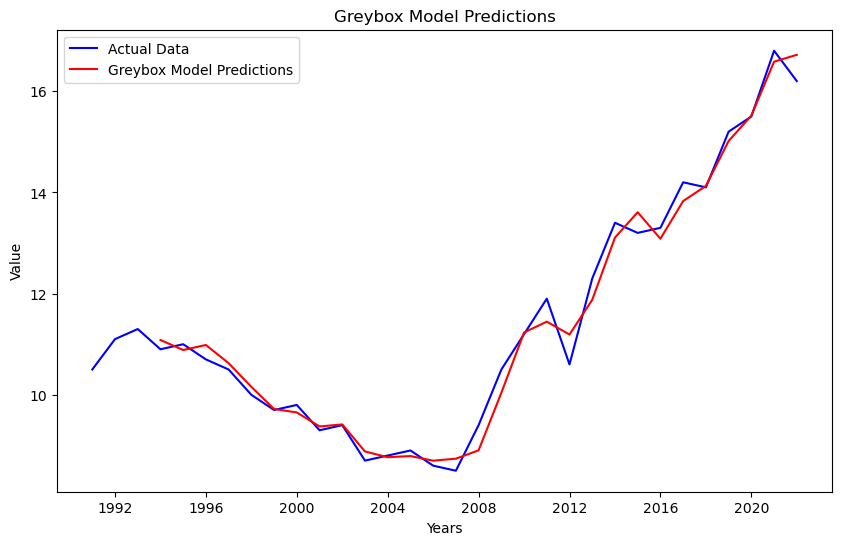

In [434]:
# Step 5: Plot the final combined predictions (Greybox model)
plt.figure(figsize=(10, 6))
plt.plot(years, data3, label="Actual Data", color='blue')
plt.plot(years[lags3:], final_forecast3, label="Greybox Model Predictions", color='red')
plt.title("Greybox Model Predictions")
plt.xlabel("Years")
plt.ylabel("Value")
plt.legend()
plt.show()



In [435]:
# Step 6: Compute evaluation metrics for the Greybox model predictions
mse3 = mean_squared_error(data3[lags3:], final_forecast3)
mape3 = mean_absolute_percentage_error(data3[lags3:], final_forecast3)
r2 = r2_score(data3[lags3:], final_forecast3)

print(f'Greybox Model Evaluation:')
print(f'R-Squared: {r2:.4f}')
print(f'MSE: {mse3:.4f}')
print(f'MAPE: {mape3:.4f}')

Greybox Model Evaluation:
R-Squared: 0.9865
MSE: 0.0789
MAPE: 0.0196


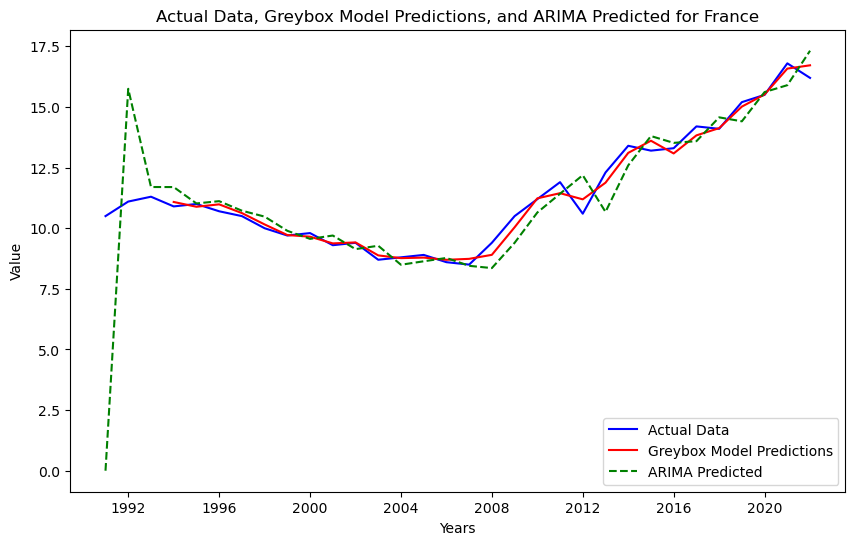

In [436]:
plt.figure(figsize=(10, 6))

# Plot Actual Data
plt.plot(years, data3, label="Actual Data", color='blue')

# Plot Greybox Model Predictions
plt.plot(years[lags3:], final_forecast3, label="Greybox Model Predictions", color='red')

# Plot ARIMA Predicted Data
plt.plot(years, pred_arima3, label='ARIMA Predicted', linestyle='--', color='green')

# Add titles, labels, and legend
plt.title("Actual Data, Greybox Model Predictions, and ARIMA Predicted for France")
plt.xlabel("Years")
plt.ylabel("Value")
plt.legend()

# Show the combined plot
plt.show()


# ANALYSING NIGERIA DATASET

# DESCRIPTIVE ANALYSIS OF THE TIME SERIES

count    32.000000
mean     84.487500
std       2.662372
min      79.900000
25%      81.750000
50%      84.500000
75%      86.650000
max      88.600000
Name: Nigeria, dtype: float64
<class 'pandas.core.series.Series'>
RangeIndex: 32 entries, 0 to 31
Series name: Nigeria
Non-Null Count  Dtype  
--------------  -----  
32 non-null     float64
dtypes: float64(1)
memory usage: 388.0 bytes
None


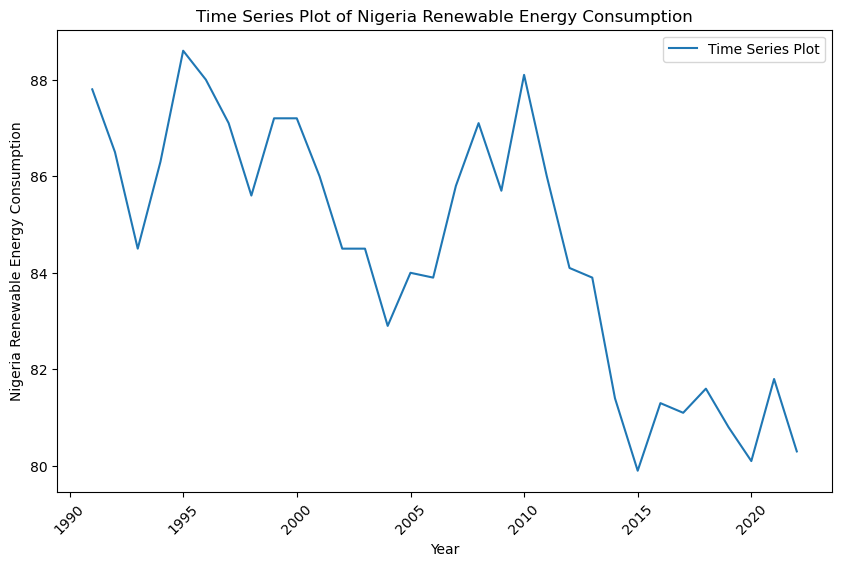

In [437]:
data4 = data['Nigeria']
# Descriptive statistics
print(data4.describe())
print(data4.info())

years = pd.date_range(start='1990', end='2022', freq='Y')

# Ensure the index of the DataFrame is set to the correct years
data4.index = years

# Plot the time series with actual years on the x-axis
plt.figure(figsize=(10,6))
plt.plot(data4, label="Time Series Plot")
plt.title("Time Series Plot of Nigeria Renewable Energy Consumption")
plt.xlabel("Year")
plt.ylabel("Nigeria Renewable Energy Consumption")
plt.legend()

# Set the x-axis to display the years in a less clustered way, e.g., every 5 years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(5))  # Display ticks every 5 years

plt.xticks(rotation=45)  # Rotate the x-axis labels to make them more readable

plt.show()

### ARIMA Model

## Plot ACF and PACF of the Series

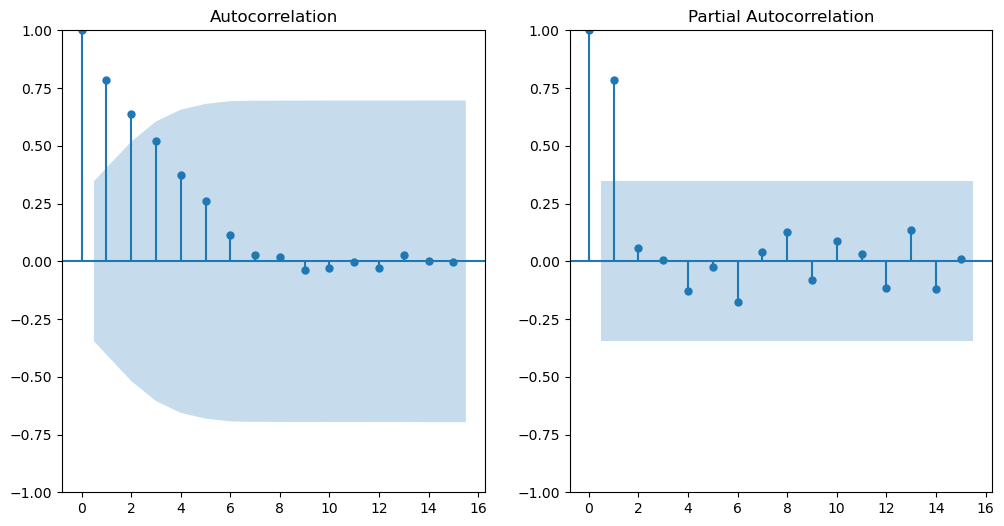

In [438]:
# Plot ACF and PACF
plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(data4, ax=plt.gca(), lags=15)
plt.subplot(122)
plot_pacf(data4, ax=plt.gca(), lags=15)
plt.show()

## Perform ADF Test on Actual Series

In [439]:
adf_result4 = adfuller(data4)
print('ADF Statistic: %f' % adf_result4[0])
print('p-value: %f' % adf_result4[1])

ADF Statistic: -1.400948
p-value: 0.581821


## Differencing the Actual Series

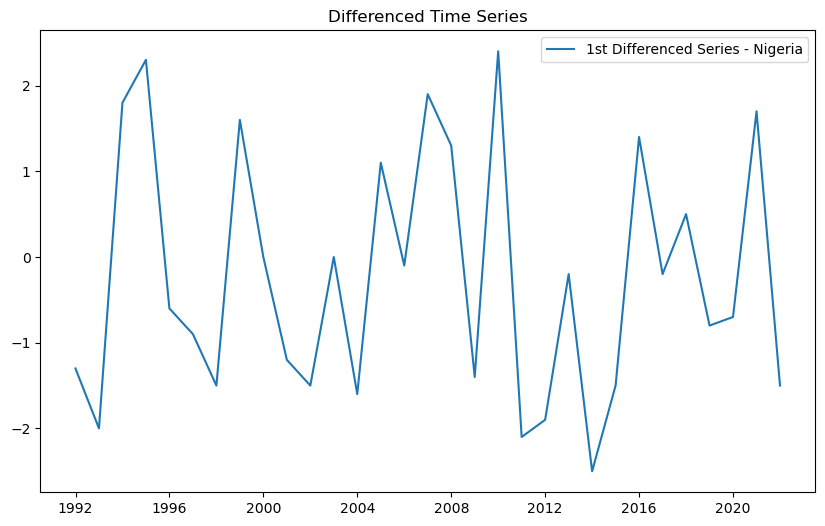

In [440]:
# Difference the series to make it stationary
data4_diff = data4.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(10,6))
plt.plot(data4_diff, label="1st Differenced Series - Nigeria")
plt.title("Differenced Time Series")
plt.legend()
plt.show()

## Plot ACF and PACF of the 1st Differenced Series

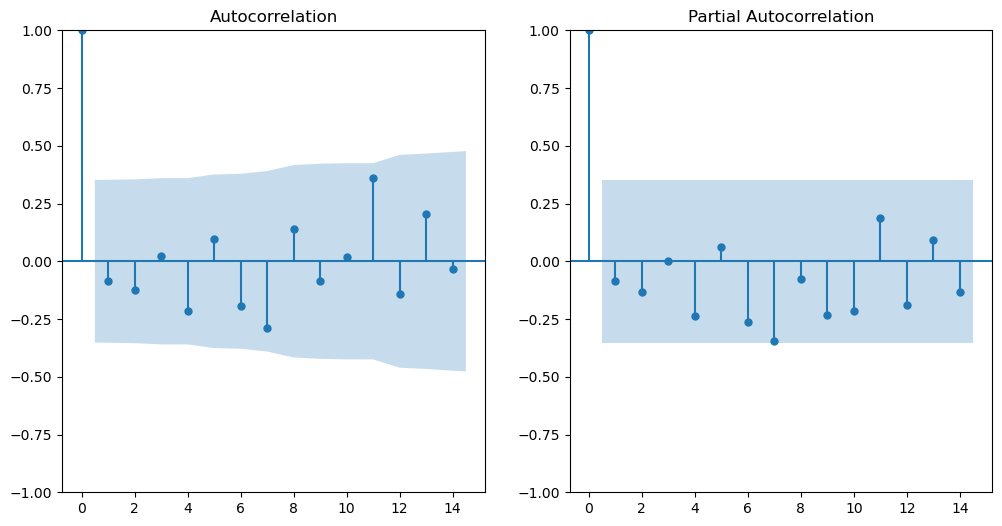

Differenced ADF Statistic: -6.477111
Differenced p-value: 0.000000


In [441]:
# ACF and PACF of differenced series
plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(data4_diff, ax=plt.gca(), lags=14)
plt.subplot(122)
plot_pacf(data4_diff, ax=plt.gca(), lags=14)
plt.show()

# ADF Test on differenced series
adf_diff_result4 = adfuller(data1_diff)
print('Differenced ADF Statistic: %f' % adf_diff_result4[0])
print('Differenced p-value: %f' % adf_diff_result4[1])

## Hyperparameter Tuning for ARIMA

In [442]:
# Define parameter ranges to test (example ranges)
p = d = q = range(0, 3)  # Try values 0, 1, 2
pdq = list(itertools.product(p, d, q))  # Generate all combinations

# Function to evaluate ARIMA models
def evaluate_arima_models(data, pdq_combinations):
    best_aic = np.inf
    best_order = None
    best_model = None
    
    for order in pdq_combinations:
        try:
            model = ARIMA(data4, order=order).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = order
                best_model = model
        except:
            continue
    
    return best_order, best_model
# Find the best ARIMA model
best_order, best_arima_model4 = evaluate_arima_models(data4, pdq)

# Print results
print(f"Best ARIMA Order: {best_order}")
print(best_arima_model4.summary())


Best ARIMA Order: (0, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                Nigeria   No. Observations:                   32
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -55.646
Date:                Sat, 13 Dec 2025   AIC                            113.292
Time:                        18:08:49   BIC                            114.726
Sample:                    12-31-1990   HQIC                           113.759
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.1216      0.934      2.271      0.023       0.290       3.953
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 2.47
Prob(Q):           

## Fit Two More ARIMA Models

In [443]:
# Fit two other ARIMA models with different orders
arima_model_1 = ARIMA(data4, order=(0,1,1)).fit()
arima_model_2 = ARIMA(data4, order=(1,1,1)).fit()
arima_model_3 = ARIMA(data4, order=(1,1,0)).fit()
arima_model_4 = ARIMA(data4, order=(0,1,2)).fit()
arima_model_5 = ARIMA(data4, order=(1,1,2)).fit()
arima_model_6 = ARIMA(data4, order=(0,2,1)).fit()
arima_model_7 = ARIMA(data4, order=(2,2,1)).fit()
arima_model_8 = ARIMA(data4, order=(1,2,2)).fit()


# Compare AIC, BIC, HQIC, LogLikelihood
print(f"ARIMA (Best) AIC: {best_arima_model2.aic}, BIC: {best_arima_model2.bic}, HQIC: {best_arima_model2.hqic}")
print(f"ARIMA (0,1,1) AIC: {arima_model_1.aic}, BIC: {arima_model_1.bic},  HQIC: {arima_model_1.hqic}")
print(f"ARIMA (1,1,1) AIC: {arima_model_2.aic}, BIC: {arima_model_2.bic}, HQIC: {arima_model_2.hqic}")
print(f"ARIMA (1,1,0) AIC: {arima_model_3.aic}, BIC: {arima_model_3.bic},  HQIC: {arima_model_3.hqic}")
print(f"ARIMA (0,1,2) AIC: {arima_model_4.aic}, BIC: {arima_model_4.bic},  HQIC: {arima_model_4.hqic}")
print(f"ARIMA (1,1,2) AIC: {arima_model_5.aic}, BIC: {arima_model_5.bic},  HQIC: {arima_model_5.hqic}")
print(f"ARIMA (0,2,1) AIC: {arima_model_6.aic}, BIC: {arima_model_6.bic},  HQIC: {arima_model_6.hqic}")
print(f"ARIMA (2,1,1) AIC: {arima_model_7.aic}, BIC: {arima_model_7.bic},  HQIC: {arima_model_7.hqic}")

ARIMA (Best) AIC: 57.286515881416285, BIC: 58.720503085901434, HQIC: 57.75395995410204
ARIMA (0,1,1) AIC: 115.12643141966772, BIC: 117.99440582863802,  HQIC: 116.06131956503923
ARIMA (1,1,1) AIC: 116.47879851187346, BIC: 120.7807601253289, HQIC: 117.88113072993072
ARIMA (1,1,0) AIC: 115.16135497381715, BIC: 118.02932938278745,  HQIC: 116.09624311918866
ARIMA (0,1,2) AIC: 116.55663405887412, BIC: 120.85859567232956,  HQIC: 117.95896627693138
ARIMA (1,1,2) AIC: 117.30702564430156, BIC: 123.04297446224214,  HQIC: 119.17680193504455
ARIMA (0,2,1) AIC: 115.27985708178049, BIC: 118.0822518451048,  HQIC: 116.17636724458666
ARIMA (2,1,1) AIC: 118.8555711594634, BIC: 124.46036068611201,  HQIC: 120.64859148507573


In [444]:
print(arima_model_1.summary())

print(arima_model_2.summary())

print(arima_model_8.summary())

                               SARIMAX Results                                
Dep. Variable:                Nigeria   No. Observations:                   32
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -55.563
Date:                Sat, 13 Dec 2025   AIC                            115.126
Time:                        18:08:51   BIC                            117.994
Sample:                    12-31-1990   HQIC                           116.061
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0831      0.189     -0.441      0.659      -0.453       0.286
sigma2         2.1099      0.927      2.275      0.023       0.292       3.927
Ljung-Box (L1) (Q):                   0.01   Jarque-

## Predict Using the Best ARIMA Model

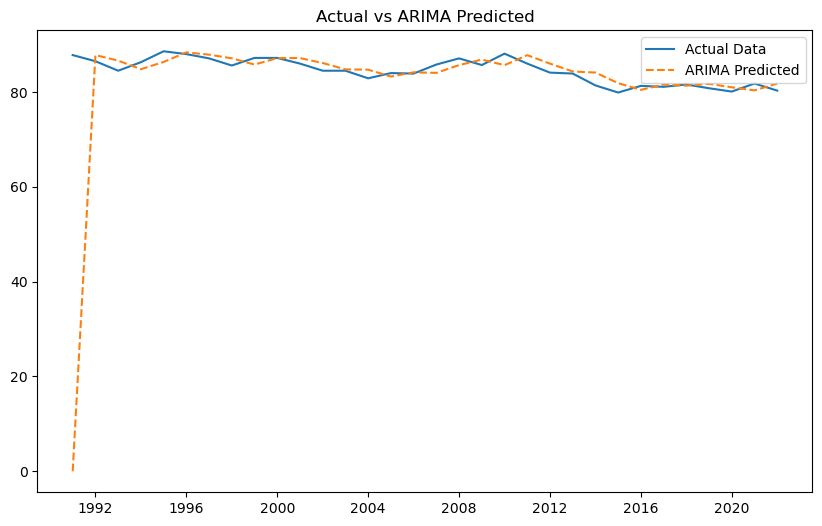

ARIMA Model - R-squared: -34.374181733508614, MSE: 242.904556975391, MAPE: 0.04571817425177896, AIC: 113.29166374931329, BIC: 118.0822518451048


In [445]:
###### Predictions using best ARIMA model
pred_arima4 = arima_model_2.predict(start=0, end=len(data4)-1)

# Plot Actual vs Predicted
plt.figure(figsize=(10,6))
plt.plot(data4, label='Actual Data')
plt.plot(data4.index, pred_arima4, label='ARIMA Predicted', linestyle='--')
plt.title('Actual vs ARIMA Predicted')
plt.legend()
plt.show()


# Compute performance metrics for ARIMA model
mse_arima4 = mean_squared_error(data4, pred_arima4)
r2_arima4 = r2_score(data4, pred_arima4)
mape_arima4 = mean_absolute_percentage_error(data4, pred_arima4)
aic_arima4 = best_arima_model4.aic
bic_arima4 = arima_model_6.bic

print(f"ARIMA Model - R-squared: {r2_arima4}, MSE: {mse_arima4}, MAPE: {mape_arima4}, AIC: {aic_arima4}, BIC: {bic_arima4}")


In [446]:
future_forecast4 = arima_model_2.forecast(steps=5) 
future_forecast4

2022-12-31    80.476106
2023-12-31    80.594848
2024-12-31    80.674911
2025-12-31    80.728894
2026-12-31    80.765293
Freq: YE-DEC, Name: predicted_mean, dtype: float64

### Fit the Grey-box Model

### Greybox modeling of time series data typically involves combining a classical time series model (like ARIMA, which forms the Whitebox component) with a data-driven model (such as a machine learning model like a neural network or random forest, which forms the Blackbox component) to enhance the predictive accuracy.

In [447]:
# Step 1: Fit the ARIMA model
best_arima_model4 = ARIMA(data4, order=(1,1,1)).fit()

# Step 2: Get the ARIMA predictions and residuals
arima_pred4 = best_arima_model4.fittedvalues
residuals4 = data4 - arima_pred4  # Residuals from ARIMA model

# Step 3: Fit a RandomForest model (Blackbox model) on the residuals
# Use lag features of the residuals as inputs
lags4 = 3  # Number of lagged features
X = pd.DataFrame({f'lag_{i}': residuals4.shift(i) for i in range(1, lags4 + 1)})

# Replace missing values (from lagging) using column mean
X.fillna(X.mean(), inplace=True)

# Define target variable y after aligning with X (dropping the first `lags` rows)
y = residuals4[lags4:]  # Align y to match the length of X
X = X[lags4:]  # Align X by removing the first `lags` rows

# Fit the RandomForest model
rf_model4 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model4.fit(X, y)

# Step 4: Make predictions using the Random Forest model
rf_pred4 = rf_model4.predict(X)

# Combine ARIMA and RandomForest predictions: Final prediction = ARIMA prediction + RF residual prediction
rf_forecast_residuals4 = rf_pred4  # Residuals predicted by Random Forest
final_forecast4 = arima_pred4[lags4:] + rf_forecast_residuals4
# Combine ARIMA and RF predictions


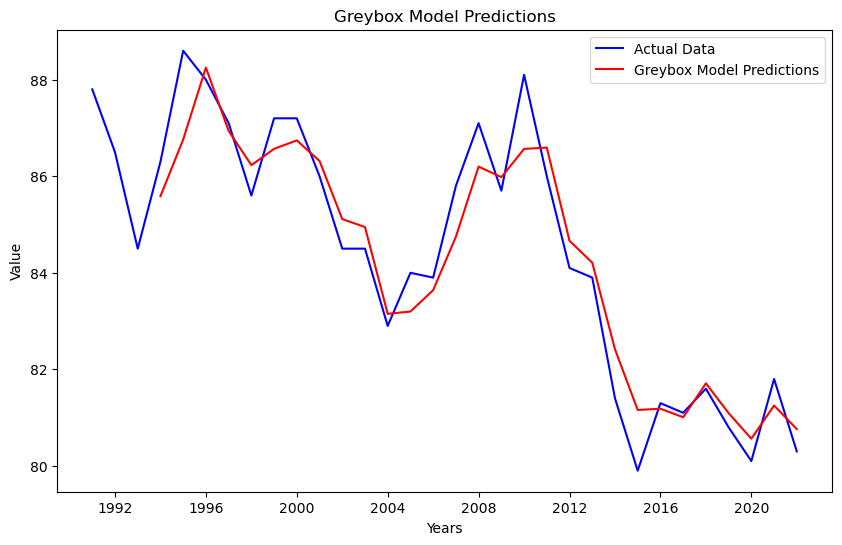

In [448]:
# Step 5: Plot the final combined predictions (Greybox model)
plt.figure(figsize=(10, 6))
plt.plot(years, data4, label="Actual Data", color='blue')
plt.plot(years[lags4:], final_forecast4, label="Greybox Model Predictions", color='red')
plt.title("Greybox Model Predictions")
plt.xlabel("Years")
plt.ylabel("Value")
plt.legend()
plt.show()

In [449]:
# Step 6: Compute evaluation metrics for the Greybox model predictions
mse4 = mean_squared_error(data4[lags4:], final_forecast4)
mape4 = mean_absolute_percentage_error(data4[lags4:], final_forecast4)
r2 = r2_score(data4[lags4:], final_forecast4)

print(f'Greybox Model Evaluation:')
print(f'R-Squared: {r2:.4f}')
print(f'MSE: {mse4:.4f}')
print(f'MAPE: {mape4:.4f}')

Greybox Model Evaluation:
R-Squared: 0.9263
MSE: 0.5178
MAPE: 0.0069


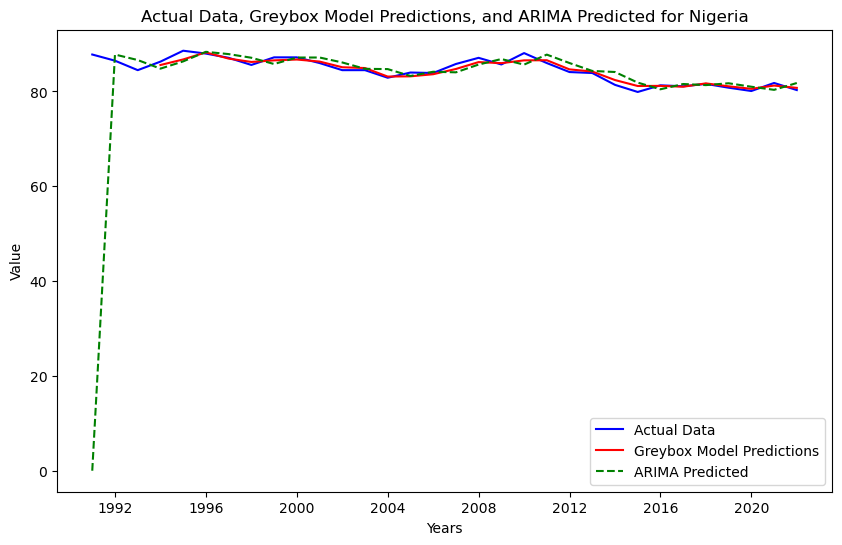

In [450]:
plt.figure(figsize=(10, 6))

# Plot Actual Data
plt.plot(years, data4, label="Actual Data", color='blue')

# Plot Greybox Model Predictions
plt.plot(years[lags4:], final_forecast4, label="Greybox Model Predictions", color='red')

# Plot ARIMA Predicted Data
plt.plot(years, pred_arima4, label='ARIMA Predicted', linestyle='--', color='green')

# Add titles, labels, and legend
plt.title("Actual Data, Greybox Model Predictions, and ARIMA Predicted for Nigeria")
plt.xlabel("Years")
plt.ylabel("Value")
plt.legend()

# Show the combined plot
plt.show()


In [451]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor


In [452]:
# Step 1: Fit the ARIMA model
best_arima_model1 = ARIMA(data1, order=(0,2,2)).fit()

# Step 2: Get the ARIMA predictions and residuals
arima_pred1 = best_arima_model1.fittedvalues
residuals1 = data1 - arima_pred1  # Residuals from ARIMA model

# Step 3: Fit a RandomForest model (Blackbox model) on the residuals
# Use lag features of the residuals as inputs
lags1 = 3  # Number of lagged features
X = pd.DataFrame({f'lag_{i}': residuals1.shift(i) for i in range(1, lags1 + 1)})

# Replace missing values (from lagging) using column mean
X.fillna(X.mean(), inplace=True)

# Define target variable y after aligning with X (dropping the first `lags` rows)
y = residuals1[lags1:]  # Align y to match the length of X
X = X[lags1:]  # Align X by removing the first `lags` rows

# Fit the RandomForest model
rf_model1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model1.fit(X, y)

# Step 4: Make predictions using the Random Forest model
rf_pred1 = rf_model1.predict(X)

# Combine ARIMA and RandomForest predictions: Final prediction = ARIMA prediction + RF residual prediction
rf_forecast_residuals1 = rf_pred1  # Residuals predicted by Random Forest
final_forecast1 = arima_pred1[lags1:] + rf_forecast_residuals1  # Combine ARIMA and RF predictions


In [453]:
# Step 1: Forecast using the ARIMA model for 2022-2050
n_forecast = 5  # Forecast for 2022-2026 (29 years)

# Forecast with ARIMA model
arima_forecast1 = best_arima_model1.forecast(steps=n_forecast)

# Step 2: Generate the ARIMA residuals for the forecast period
# We don't have actual values for residuals, so we'll need to generate lag features for ARIMA residuals.
# Let's assume that the residuals for 2022-2050 follow the same distribution as those for the training data.
# We'll take the last few residuals from the training period to predict the residuals for the forecast period.

# Create lag features for residuals (up to the same `lags3` as before)
residuals_lagged = pd.DataFrame({f'lag_{i}': residuals1.shift(i) for i in range(1, lags1 + 1)})

# Fill missing values (for lagged residuals)
residuals_lagged.fillna(residuals_lagged.mean(), inplace=True)

# Use the most recent residuals to predict future residuals
last_residuals = residuals_lagged.iloc[-1]  # Take the last residuals for prediction

# Create a new dataframe with lagged residuals for forecast period
future_residuals = pd.DataFrame([last_residuals] * n_forecast)
# Fit the Random Forest model to predict future residuals
rf_forecast_residuals1 = rf_model1.predict(future_residuals)

# Step 3: Combine ARIMA and Random Forest predictions to get the final forecast
final_forecast1 = arima_forecast1 + rf_forecast_residuals1
final_forecast1
# Step 4: Output the forecast for 2022-2050
forecast_years = pd.date_range(start="2022", end="2027", freq="Y").year

In [454]:
forecast_results = pd.DataFrame({
    "Year": forecast_years,
    "ARIMA Forecast": arima_forecast1,
    "Random Forest Residuals": rf_forecast_residuals1,
    "Final Forecast": final_forecast1
})

# Display forecasted results
print(forecast_results)

            Year  ARIMA Forecast  Random Forest Residuals  Final Forecast
2022-12-31  2022       58.579944                -3.946184       54.633760
2023-12-31  2023       59.830299                -3.946184       55.884115
2024-12-31  2024       61.080654                -3.946184       57.134470
2025-12-31  2025       62.331009                -3.946184       58.384825
2026-12-31  2026       63.581364                -3.946184       59.635180


In [455]:
# Step 1: Fit the ARIMA model
best_arima_model2 = ARIMA(data2, order=(0,2,1)).fit()

# Step 2: Get the ARIMA predictions and residuals
arima_pred2 = best_arima_model2.fittedvalues
residuals2 = data2 - arima_pred2  # Residuals from ARIMA model

# Step 3: Fit a RandomForest model (Blackbox model) on the residuals
# Use lag features of the residuals as inputs
lags2 = 3  # Number of lagged features
X = pd.DataFrame({f'lag_{i}': residuals2.shift(i) for i in range(1, lags2 + 1)})

# Replace missing values (from lagging) using column mean
X.fillna(X.mean(), inplace=True)

# Define target variable y after aligning with X (dropping the first `lags` rows)
y = residuals2[lags2:]  # Align y to match the length of X
X = X[lags2:]  # Align X by removing the first `lags` rows

# Fit the RandomForest model
rf_model2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model2.fit(X, y)

# Step 4: Make predictions using the Random Forest model
rf_pred2 = rf_model2.predict(X)

# Combine ARIMA and RandomForest predictions: Final prediction = ARIMA prediction + RF residual prediction
rf_forecast_residuals2 = rf_pred2  # Residuals predicted by Random Forest
final_forecast2 = arima_pred2[lags2:] + rf_forecast_residuals2  # Combine ARIMA and RF predictions


In [456]:
# Step 1: Forecast using the ARIMA model for 2022-2050
n_forecast = 5  # Forecast for 2022-2050 (29 years)

# Forecast with ARIMA model
arima_forecast2 = best_arima_model2.forecast(steps=n_forecast)

# Step 2: Generate the ARIMA residuals for the forecast period
# We don't have actual values for residuals, so we'll need to generate lag features for ARIMA residuals.
# Let's assume that the residuals for 2022-2050 follow the same distribution as those for the training data.
# We'll take the last few residuals from the training period to predict the residuals for the forecast period.

# Create lag features for residuals (up to the same `lags3` as before)
residuals_lagged = pd.DataFrame({f'lag_{i}': residuals2.shift(i) for i in range(1, lags2 + 1)})

# Fill missing values (for lagged residuals)
residuals_lagged.fillna(residuals_lagged.mean(), inplace=True)

# Use the most recent residuals to predict future residuals
last_residuals = residuals_lagged.iloc[-1]  # Take the last residuals for prediction

# Create a new dataframe with lagged residuals for forecast period
future_residuals = pd.DataFrame([last_residuals] * n_forecast)
# Fit the Random Forest model to predict future residuals
rf_forecast_residuals2 = rf_model2.predict(future_residuals)

# Step 3: Combine ARIMA and Random Forest predictions to get the final forecast
final_forecast2 = arima_forecast2 + rf_forecast_residuals2
final_forecast2
# Step 4: Output the forecast for 2022-2050
forecast_years = pd.date_range(start="2022", end="2027", freq="Y").year

In [457]:
forecast_results = pd.DataFrame({
    "Year": forecast_years,
    "ARIMA Forecast": arima_forecast2,
    "Random Forest Residuals": rf_forecast_residuals2,
    "Final Forecast": final_forecast2
})

# Display forecasted results
print(forecast_results)

            Year  ARIMA Forecast  Random Forest Residuals  Final Forecast
2022-12-31  2022       23.915515                -0.093361       23.822154
2023-12-31  2023       24.031029                -0.093361       23.937668
2024-12-31  2024       24.146544                -0.093361       24.053183
2025-12-31  2025       24.262059                -0.093361       24.168698
2026-12-31  2026       24.377573                -0.093361       24.284212


In [458]:
# Step 1: Fit the ARIMA model
best_arima_model3 = ARIMA(data3, order=(0,2,1)).fit()

# Step 2: Get the ARIMA predictions and residuals
arima_pred3 = best_arima_model3.fittedvalues
residuals3 = data3 - arima_pred3  # Residuals from ARIMA model

# Step 3: Fit a RandomForest model (Blackbox model) on the residuals
# Use lag features of the residuals as inputs
lags3 = 3  # Number of lagged features
X = pd.DataFrame({f'lag_{i}': residuals3.shift(i) for i in range(1, lags3 + 1)})

# Replace missing values (from lagging) using column mean
X.fillna(X.mean(), inplace=True)

# Define target variable y after aligning with X (dropping the first `lags` rows)
y = residuals3[lags3:]  # Align y to match the length of X
X = X[lags3:]  # Align X by removing the first `lags` rows

# Fit the RandomForest model
rf_model3 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model3.fit(X, y)

# Step 4: Make predictions using the Random Forest model
rf_pred3 = rf_model3.predict(X)

# Combine ARIMA and RandomForest predictions: Final prediction = ARIMA prediction + RF residual prediction
rf_forecast_residuals3 = rf_pred3  # Residuals predicted by Random Forest
final_forecast3 = arima_pred3[lags3:] + rf_forecast_residuals3  # Combine ARIMA and RF predictions


In [459]:
# Step 1: Forecast using the ARIMA model for 2022-2050
n_forecast = 5  # Forecast for 2022-2050 (29 years)

# Forecast with ARIMA model
arima_forecast3 = best_arima_model3.forecast(steps=n_forecast)

# Step 2: Generate the ARIMA residuals for the forecast period
# We don't have actual values for residuals, so we'll need to generate lag features for ARIMA residuals.
# Let's assume that the residuals for 2022-2050 follow the same distribution as those for the training data.
# We'll take the last few residuals from the training period to predict the residuals for the forecast period.

# Create lag features for residuals (up to the same `lags3` as before)
residuals_lagged = pd.DataFrame({f'lag_{i}': residuals3.shift(i) for i in range(1, lags3 + 1)})

# Fill missing values (for lagged residuals)
residuals_lagged.fillna(residuals_lagged.mean(), inplace=True)

# Use the most recent residuals to predict future residuals
last_residuals = residuals_lagged.iloc[-1]  # Take the last residuals for prediction

# Create a new dataframe with lagged residuals for forecast period
future_residuals = pd.DataFrame([last_residuals] * n_forecast)
# Fit the Random Forest model to predict future residuals
rf_forecast_residuals3 = rf_model3.predict(future_residuals)

# Step 3: Combine ARIMA and Random Forest predictions to get the final forecast
final_forecast3 = arima_forecast3 + rf_forecast_residuals3
final_forecast3
# Step 4: Output the forecast for 2022-2050
forecast_years = pd.date_range(start="2022", end="2027", freq="Y").year

In [460]:
forecast_results = pd.DataFrame({
    "Year": forecast_years,
    "ARIMA Forecast": arima_forecast3,
    "Random Forest Residuals": rf_forecast_residuals3,
    "Final Forecast": final_forecast3
})

# Display forecasted results
print(forecast_results)

            Year  ARIMA Forecast  Random Forest Residuals  Final Forecast
2022-12-31  2022       16.570273                -0.601499       15.968773
2023-12-31  2023       16.940546                -0.601499       16.339046
2024-12-31  2024       17.310818                -0.601499       16.709319
2025-12-31  2025       17.681091                -0.601499       17.079592
2026-12-31  2026       18.051364                -0.601499       17.449864


In [461]:
# Step 1: Fit the ARIMA model
best_arima_model4 = ARIMA(data4, order=(1,1,1)).fit()

# Step 2: Get the ARIMA predictions and residuals
arima_pred4 = best_arima_model4.fittedvalues
residuals4 = data4 - arima_pred4  # Residuals from ARIMA model

# Step 3: Fit a RandomForest model (Blackbox model) on the residuals
# Use lag features of the residuals as inputs
lags4 = 3  # Number of lagged features
X = pd.DataFrame({f'lag_{i}': residuals4.shift(i) for i in range(1, lags4 + 1)})

# Replace missing values (from lagging) using column mean
X.fillna(X.mean(), inplace=True)

# Define target variable y after aligning with X (dropping the first `lags` rows)
y = residuals4[lags4:]  # Align y to match the length of X
X = X[lags4:]  # Align X by removing the first `lags` rows

# Fit the RandomForest model
rf_model4 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model4.fit(X, y)

# Step 4: Make predictions using the Random Forest model
rf_pred4 = rf_model4.predict(X)

# Combine ARIMA and RandomForest predictions: Final prediction = ARIMA prediction + RF residual prediction
rf_forecast_residuals4 = rf_pred4  # Residuals predicted by Random Forest
final_forecast4 = arima_pred4[lags4:] + rf_forecast_residuals4  # Combine ARIMA and RF predictions


In [462]:
# Step 1: Forecast using the ARIMA model for 2022-2050
n_forecast = 5  # Forecast for 2022-2050 (29 years)

# Forecast with ARIMA model
arima_forecast4 = best_arima_model4.forecast(steps=n_forecast)

# Step 2: Generate the ARIMA residuals for the forecast period
# We don't have actual values for residuals, so we'll need to generate lag features for ARIMA residuals.
# Let's assume that the residuals for 2022-2050 follow the same distribution as those for the training data.
# We'll take the last few residuals from the training period to predict the residuals for the forecast period.

# Create lag features for residuals (up to the same `lags3` as before)
residuals_lagged = pd.DataFrame({f'lag_{i}': residuals4.shift(i) for i in range(1, lags4 + 1)})

# Fill missing values (for lagged residuals)
residuals_lagged.fillna(residuals_lagged.mean(), inplace=True)

# Use the most recent residuals to predict future residuals
last_residuals = residuals_lagged.iloc[-1]  # Take the last residuals for prediction

# Create a new dataframe with lagged residuals for forecast period
future_residuals = pd.DataFrame([last_residuals] * n_forecast)
# Fit the Random Forest model to predict future residuals
rf_forecast_residuals4 = rf_model4.predict(future_residuals)

# Step 3: Combine ARIMA and Random Forest predictions to get the final forecast
final_forecast4 = arima_forecast4 + rf_forecast_residuals4
final_forecast4
# Step 4: Output the forecast for 2022-2050
forecast_years = pd.date_range(start="2022", end="2027", freq="Y").year

In [463]:
forecast_results = pd.DataFrame({
    "Year": forecast_years,
    "ARIMA Forecast": arima_forecast4,
    "Random Forest Residuals": rf_forecast_residuals4,
    "Final Forecast": final_forecast4
})

# Display forecasted results
print(forecast_results)

            Year  ARIMA Forecast  Random Forest Residuals  Final Forecast
2022-12-31  2022       80.476106                -1.028053       79.448054
2023-12-31  2023       80.594848                -1.028053       79.566795
2024-12-31  2024       80.674911                -1.028053       79.646858
2025-12-31  2025       80.728894                -1.028053       79.700841
2026-12-31  2026       80.765293                -1.028053       79.737240


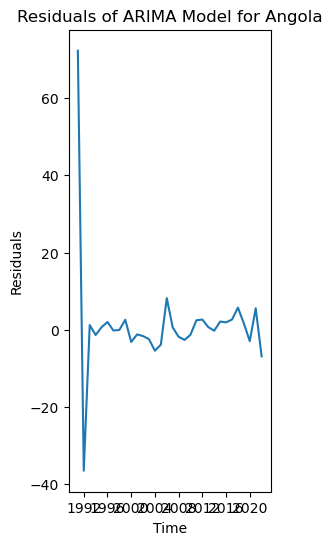

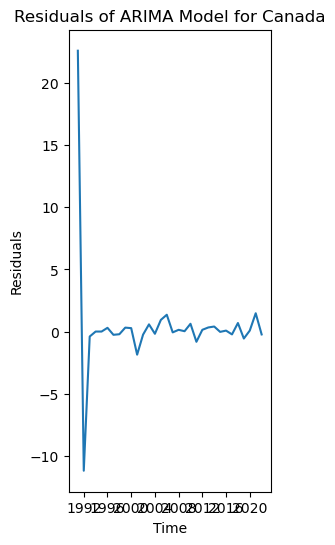

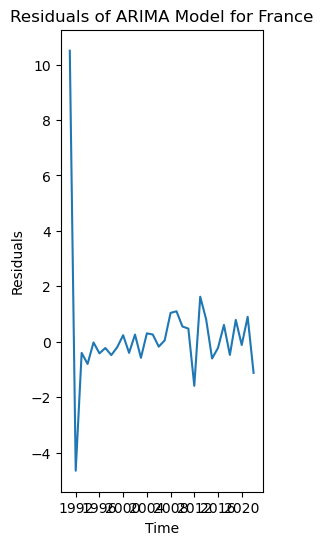

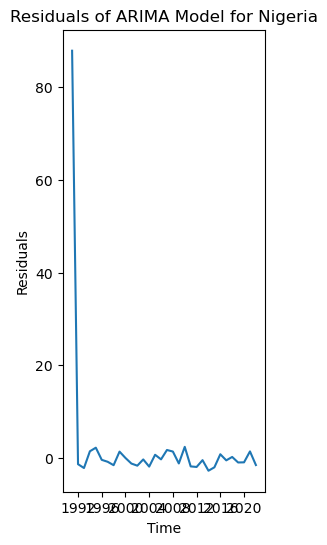

In [464]:
plt.figure(figsize=(12, 6))
plt.subplot(141)
residuals_arima1 = data1 - pred_arima1
plt.plot(residuals_arima1)
plt.title('Residuals of ARIMA Model for Angola')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.figure(figsize=(12, 6))
plt.subplot(142)
residuals_arima2 = data2 - pred_arima2
plt.plot(residuals_arima2)
plt.title('Residuals of ARIMA Model for Canada')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.figure(figsize=(12, 6))
plt.subplot(143)
residuals_arima3 = data3 - pred_arima3
plt.plot(residuals_arima3)
plt.title('Residuals of ARIMA Model for France')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.figure(figsize=(12, 6))
plt.subplot(144)
residuals_arima4 = data4 - pred_arima4
plt.plot(residuals_arima4)
plt.title('Residuals of ARIMA Model for Nigeria')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

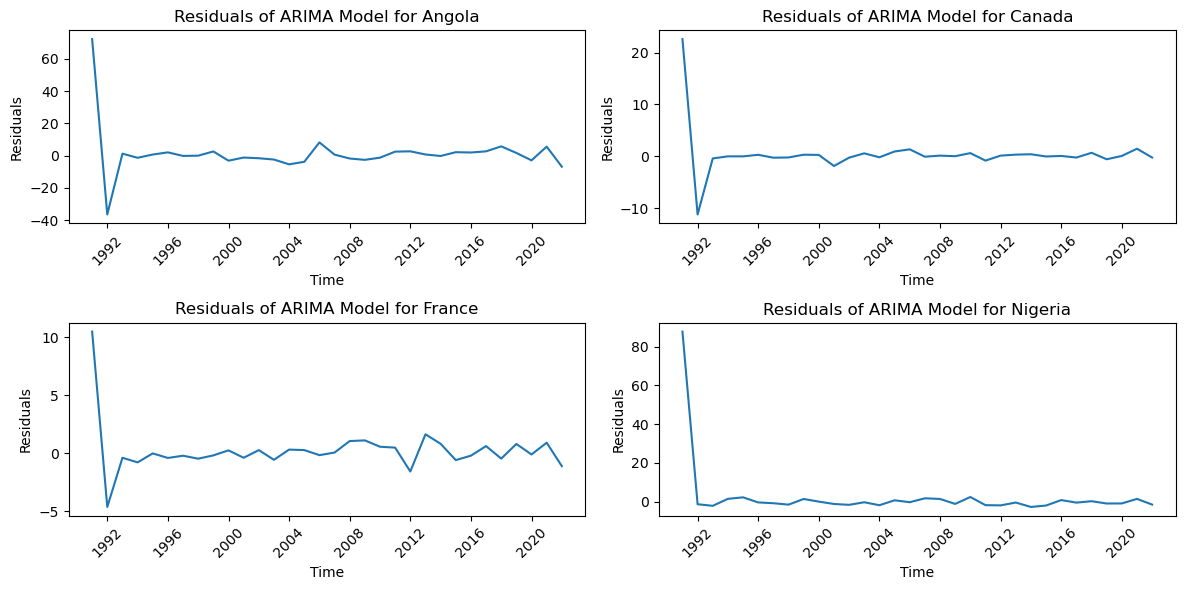

In [465]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))  # 2x2 grid, adjust figsize for better display

# First plot (Angola)
axes[0, 0].plot(residuals_arima1)
axes[0, 0].set_title('Residuals of ARIMA Model for Angola')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Residuals')

# Second plot (Canada)
axes[0, 1].plot(residuals_arima2)
axes[0, 1].set_title('Residuals of ARIMA Model for Canada')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Residuals')

# Third plot (France)
axes[1, 0].plot(residuals_arima3)
axes[1, 0].set_title('Residuals of ARIMA Model for France')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Residuals')

# Fourth plot (Nigeria)
axes[1, 1].plot(residuals_arima4)
axes[1, 1].set_title('Residuals of ARIMA Model for Nigeria')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Residuals')

# Rotate x-axis labels for better visibility (if needed)
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better visibility

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

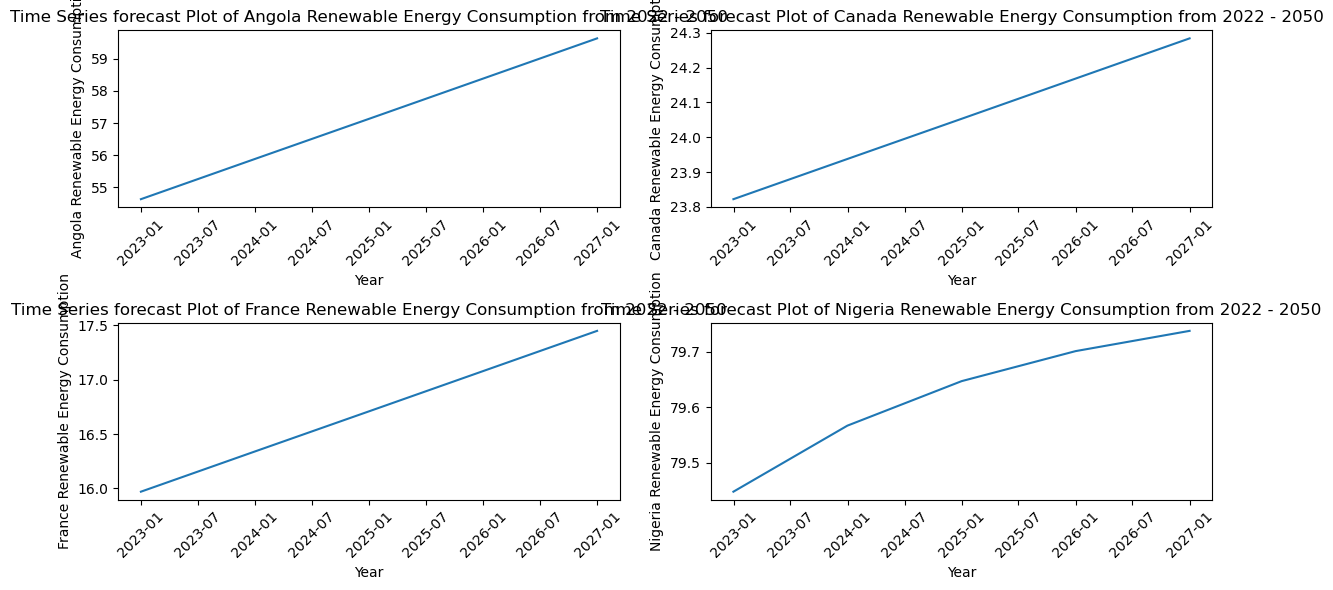

In [466]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))  # 2x2 grid, adjust figsize for better display

# First plot (Angola)
axes[0, 0].plot(final_forecast1, label="Time Series forecast Plot")
axes[0, 0].set_title("Time Series forecast Plot of Angola Renewable Energy Consumption from 2022 - 2050")
axes[0, 0].set_xlabel("Year")
axes[0, 0].set_ylabel("Angola Renewable Energy Consumption")

# Second plot (Canada)
axes[0, 1].plot(final_forecast2, label="Time Series forecast Plot")
axes[0, 1].set_title("Time Series forecast Plot of Canada Renewable Energy Consumption from 2022 - 2050")
axes[0, 1].set_xlabel("Year")
axes[0, 1].set_ylabel("Canada Renewable Energy Consumption")

# Third plot (France)
axes[1, 0].plot(final_forecast3, label="Time Series forecast Plot")
axes[1, 0].set_title("Time Series forecast Plot of France Renewable Energy Consumption from 2022 - 2050")
axes[1, 0].set_xlabel("Year")
axes[1, 0].set_ylabel("France Renewable Energy Consumption")

# Fourth plot (Nigeria)
axes[1, 1].plot(final_forecast4, label="Time Series forecast Plot")
axes[1, 1].set_title("Time Series forecast Plot of Nigeria Renewable Energy Consumption from 2022 - 2050")
axes[1, 1].set_xlabel("Year")
axes[1, 1].set_ylabel("Nigeria Renewable Energy Consumption")

# Rotate x-axis labels for better visibility (if needed)
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better visibility

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

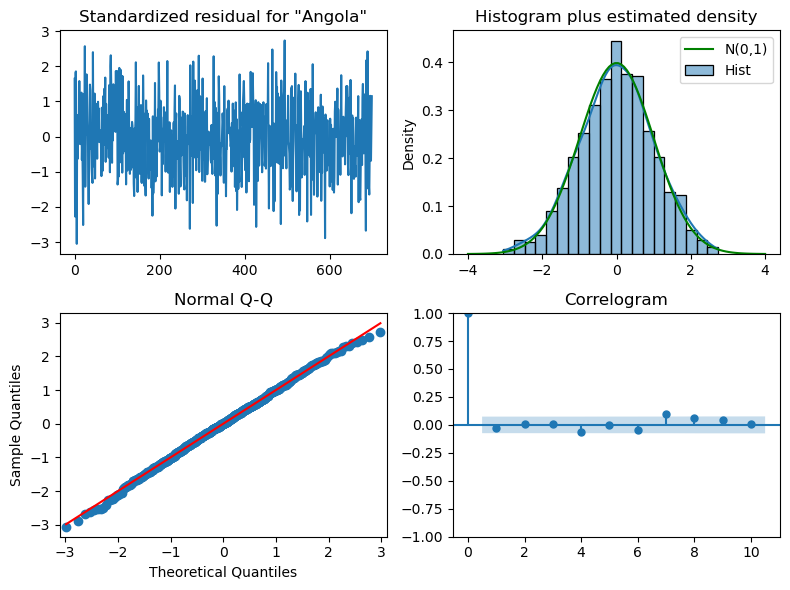

In [467]:
# Simulated data for demonstration
np.random.seed(0)
data1 = pd.Series(np.random.normal(loc=0, scale=1, size=700))

# Fit an ARIMA model (can be ARIMA, SARIMA, etc.)
model = ARIMA(data1, order=(0, 2, 2))
fitted_model = model.fit()
residuals = fitted_model.resid
standardized_residuals = (residuals - residuals.mean()) / residuals.std()

# Set up the plot
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Top-left: Standardized residuals time series
axs[0, 0].plot(standardized_residuals)
axs[0, 0].set_title('Standardized residual for "Angola"')

# Top-right: Histogram with KDE and Normal PDF
sns.histplot(standardized_residuals, kde=True, stat='density', ax=axs[0, 1], label='Hist')
x = np.linspace(-4, 4, 100)
axs[0, 1].plot(x, norm.pdf(x), color='green', label='N(0,1)')
axs[0, 1].legend()
axs[0, 1].set_title('Histogram plus estimated density')

# Bottom-left: Q-Q plot
qqplot(standardized_residuals, line='s', ax=axs[1, 0])
axs[1, 0].set_title('Normal Q-Q')

# Bottom-right: ACF plot
# Plot ACF with confidence intervals
plot_acf(standardized_residuals, lags=10, ax=axs[1, 1])
axs[1, 1].set_title('Correlogram')

plt.tight_layout()
plt.show()

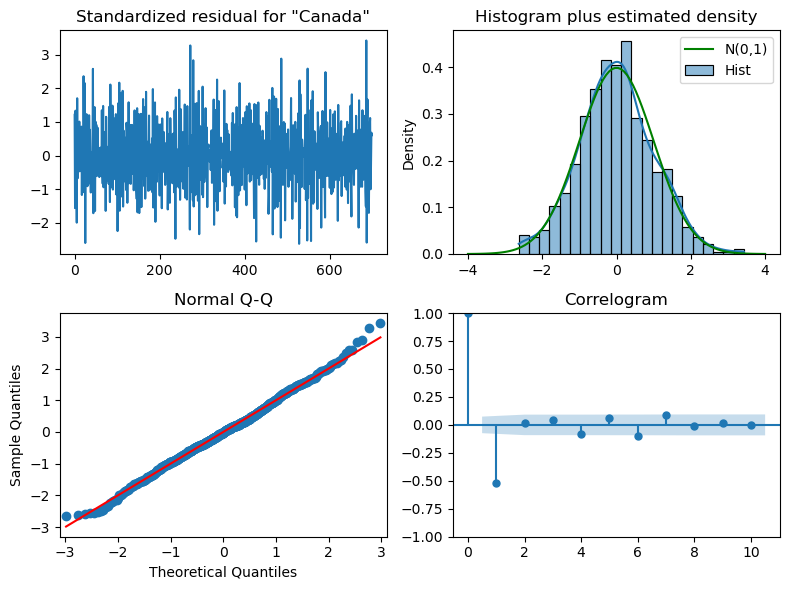

In [468]:
# Simulated data for demonstration
np.random.seed(0)
data2 = pd.Series(np.random.normal(loc=0, scale=1, size=700))

# Fit an ARIMA model (can be ARIMA, SARIMA, etc.)
model = ARIMA(data2, order=(0, 2, 1))
fitted_model = model.fit()
residuals = fitted_model.resid
standardized_residuals = (residuals - residuals.mean()) / residuals.std()

# Set up the plot
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Top-left: Standardized residuals time series
axs[0, 0].plot(standardized_residuals)
axs[0, 0].set_title('Standardized residual for "Canada"')

# Top-right: Histogram with KDE and Normal PDF
sns.histplot(standardized_residuals, kde=True, stat='density', ax=axs[0, 1], label='Hist')
x = np.linspace(-4, 4, 100)
axs[0, 1].plot(x, norm.pdf(x), color='green', label='N(0,1)')
axs[0, 1].legend()
axs[0, 1].set_title('Histogram plus estimated density')

# Bottom-left: Q-Q plot
qqplot(standardized_residuals, line='s', ax=axs[1, 0])
axs[1, 0].set_title('Normal Q-Q')

# Bottom-right: ACF plot
# Plot ACF with confidence intervals
plot_acf(standardized_residuals, lags=10, ax=axs[1, 1])
axs[1, 1].set_title('Correlogram')

plt.tight_layout()
plt.show()

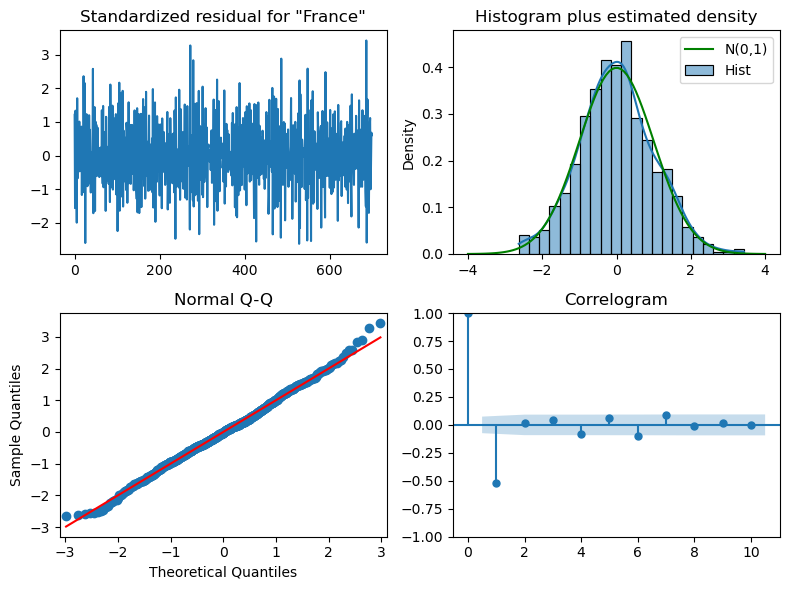

In [469]:
# Simulated data for demonstration
np.random.seed(0)
data3 = pd.Series(np.random.normal(loc=0, scale=1, size=700))

# Fit an ARIMA model (can be ARIMA, SARIMA, etc.)
model = ARIMA(data3, order=(0, 2, 1))
fitted_model = model.fit()
residuals = fitted_model.resid
standardized_residuals = (residuals - residuals.mean()) / residuals.std()

# Set up the plot
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Top-left: Standardized residuals time series
axs[0, 0].plot(standardized_residuals)
axs[0, 0].set_title('Standardized residual for "France"')

# Top-right: Histogram with KDE and Normal PDF
sns.histplot(standardized_residuals, kde=True, stat='density', ax=axs[0, 1], label='Hist')
x = np.linspace(-4, 4, 100)
axs[0, 1].plot(x, norm.pdf(x), color='green', label='N(0,1)')
axs[0, 1].legend()
axs[0, 1].set_title('Histogram plus estimated density')

# Bottom-left: Q-Q plot
qqplot(standardized_residuals, line='s', ax=axs[1, 0])
axs[1, 0].set_title('Normal Q-Q')

# Bottom-right: ACF plot
# Plot ACF with confidence intervals
plot_acf(standardized_residuals, lags=10, ax=axs[1, 1])
axs[1, 1].set_title('Correlogram')

plt.tight_layout()
plt.show()

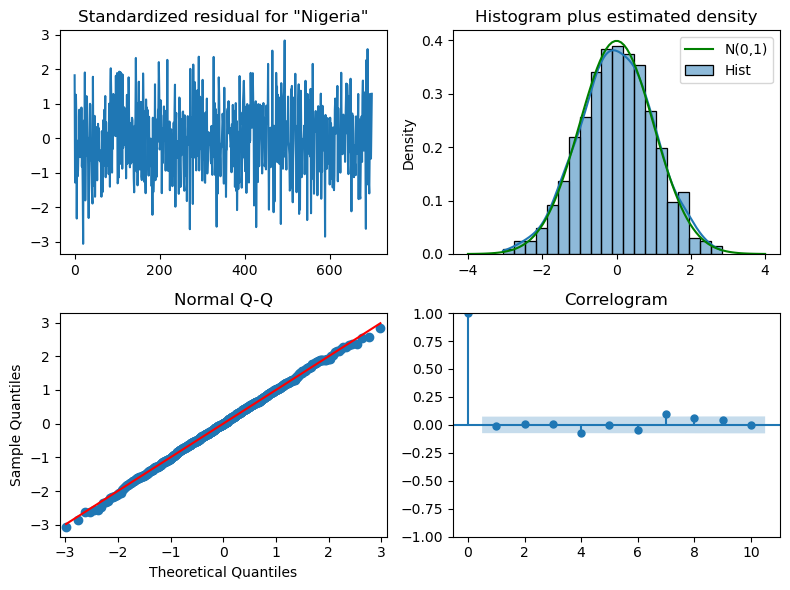

In [470]:
# Simulated data for demonstration
np.random.seed(0)
data4 = pd.Series(np.random.normal(loc=0, scale=1, size=700))

# Fit an ARIMA model (can be ARIMA, SARIMA, etc.)
model = ARIMA(data4, order=(1, 1, 1))
fitted_model = model.fit()
residuals = fitted_model.resid
standardized_residuals = (residuals - residuals.mean()) / residuals.std()

# Set up the plot
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Top-left: Standardized residuals time series
axs[0, 0].plot(standardized_residuals)
axs[0, 0].set_title('Standardized residual for "Nigeria"')

# Top-right: Histogram with KDE and Normal PDF
sns.histplot(standardized_residuals, kde=True, stat='density', ax=axs[0, 1], label='Hist')
x = np.linspace(-4, 4, 100)
axs[0, 1].plot(x, norm.pdf(x), color='green', label='N(0,1)')
axs[0, 1].legend()
axs[0, 1].set_title('Histogram plus estimated density')

# Bottom-left: Q-Q plot
qqplot(standardized_residuals, line='s', ax=axs[1, 0])
axs[1, 0].set_title('Normal Q-Q')

# Bottom-right: ACF plot
# Plot ACF with confidence intervals
plot_acf(standardized_residuals, lags=10, ax=axs[1, 1])
axs[1, 1].set_title('Correlogram')

plt.tight_layout()
plt.show()